<a href="https://colab.research.google.com/github/a-foote/DATA586G8_FraudDetector/blob/alyssa/Model_NN%20Classifier_Balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Credit Card Fraud Detector - Neural Net Classifier Model

## Template: Lab 2 and Lab 3

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import seaborn as sn
import numpy as np

In [3]:
#df_train = pd.read_csv('fraud_trainset.csv')
df_train = pd.read_csv('fraud_trainset_smote.csv')
#X_train = df_train.iloc[:,-1]
#y_train = df_train['Class'].values

In [4]:
#df_val = pd.read_csv('fraud_valset.csv')
df_val = pd.read_csv('fraud_valset_smote.csv')
#X_val = df_val.iloc[:,-1]
#y_val = df_val['Class'].values

In [5]:
df_test = pd.read_csv('fraud_testset.csv')
#X_test = df_test.iloc[:,-1]
#y_test = df_test['Class'].values

In [6]:
# Convert dataframe to numpy array for downstream model processing

train_dataset=df_train.to_numpy() #This is used in dataloader
test_dataset=df_test.to_numpy() #This is used in dataloader


## Validate the data in the train dataset to ensure the records are transformed correctly as expected

In [7]:
train_dataset.shape

(459167, 31)

In [8]:
df_train.head()

,amount_scaled,time_scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.146720,0.437963,2.072815,-0.274020,-1.461536,0.390729,0.169042,-0.451219,0.002638,-0.174516,...,-0.214453,0.098887,0.527270,-0.001204,0.550820,0.245880,0.709438,-0.078027,-0.067661,0
1,1.445476,-0.102051,-4.970521,3.432079,-5.314765,4.094720,-3.890290,-1.799163,-5.099047,2.143258,...,0.235769,1.121876,0.136211,-0.367362,0.156025,0.100632,-0.235917,0.212967,0.755191,1
2,-0.289387,1.017681,2.013691,-0.108723,-1.007693,0.323577,-0.145682,-0.946591,0.071817,-0.184335,...,-0.227993,-0.233649,-0.582757,0.341730,0.072900,-0.346356,0.173302,-0.075417,-0.069613,0
3,-0.305736,0.833645,-1.887328,0.856580,0.660617,-0.643041,-0.261658,-0.052315,-0.832577,0.273245,...,-0.568695,0.753342,-0.618488,-0.149734,-0.516402,-0.275556,-0.595123,-0.128462,-0.119148,0
4,-0.293440,-0.179866,1.239337,0.622954,-0.249949,1.318213,-0.028978,-1.213163,0.254201,-0.208548,...,-0.146088,-0.059217,-0.130362,-0.111587,0.259646,0.669972,-0.325467,0.027764,0.049900,0


In [9]:
train_dataset

array([[-1.46719765e-01,  4.37963322e-01,  2.07281502e+00, ...,
        -7.80267650e-02, -6.76609070e-02,  0.00000000e+00],
       [ 1.44547590e+00, -1.02051358e-01, -4.97052101e+00, ...,
         2.12967285e-01,  7.55190905e-01,  1.00000000e+00],
       [-2.89387270e-01,  1.01768113e+00,  2.01369065e+00, ...,
        -7.54166660e-02, -6.96130540e-02,  0.00000000e+00],
       ...,
       [-1.67819465e-01, -5.12541266e-01,  1.12068473e+00, ...,
         5.33814750e-02,  2.20964590e-02,  0.00000000e+00],
       [ 7.74300460e-01, -2.24148479e-01,  1.21711379e+00, ...,
        -9.71080100e-03,  2.22405190e-02,  1.00000000e+00],
       [ 1.21280101e+00, -3.00925617e-01, -1.72857466e+01, ...,
        -2.88240517e+00, -9.88252791e-01,  1.00000000e+00]])

## Neural Net Model

In [10]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.1
BATCH_SIZE = 40000
NUM_EPOCHS = 100

# Architecture
NUM_FEATURES = 30
NUM_CLASSES = 2

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

GRAYSCALE = False

In [11]:
###########################
### Dataset
##########################

#Transform and augmentation, validation, 

#Split X (features) and y (targets) for the dataset
X=np.delete(train_dataset,-1,axis=1)
y = np.delete(train_dataset,np.s_[0:30],axis=1).flatten()


#View a sample of X and y

X
y

array([0., 1., 0., ..., 0., 1., 1.])

In [12]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):
    loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=BATCH_SIZE)
    for batch_idx, (X_batch, y_batch) in enumerate(loader):
           
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y_batch.size()[0])
        
        x_b = X_batch
        print(x_b)
        y_b = y_batch
        print(y_b)
        break

Epoch: 1 | Batch index: 0 | Batch size: 40000
tensor([[-2.5152e-01, -2.7084e-01,  1.1971e+00,  ...,  4.7724e-01,
         -2.9792e-02, -6.0214e-03],
        [ 6.6139e-01, -5.1126e-01, -6.7381e+00,  ...,  1.4420e-01,
          1.3613e+00,  6.4440e-02],
        [-2.8799e-01,  1.2039e-01,  1.3883e-01,  ...,  4.2559e-01,
          6.0850e-01,  4.5164e-01],
        ...,
        [ 3.1987e-01,  2.7500e-01, -6.8560e+00,  ...,  2.8038e-01,
          2.9111e-01,  1.6503e+00],
        [-2.2111e-01,  8.4047e-01,  6.4016e-01,  ...,  1.8961e-02,
          8.4350e-01,  4.3921e-01],
        [-2.9344e-01, -8.5632e-01, -1.9163e+00,  ...,  4.9715e-01,
          1.7921e+00,  6.6834e-01]], dtype=torch.float64)
tensor([0., 1., 1.,  ..., 1., 1., 1.], dtype=torch.float64)
Epoch: 2 | Batch index: 0 | Batch size: 40000
tensor([[-2.9282e-01, -4.3215e-01,  3.1924e-01,  ..., -1.8782e-02,
          5.6259e-01,  3.1521e-01],
        [-2.3769e-01, -1.8232e-01,  1.2295e+00,  ...,  1.0298e-01,
         -3.8987e-02,  1.

In [13]:
##########################
### MODEL
##########################

## 4/29Add dropout
class NeuNet(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(NeuNet, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            #nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            #nn.Conv1d(28,50,kernel_size=5),
            #nn.Tanh(),
            #nn.MaxPool2d(kernel_size=2),
            #nn.MaxPool1d(kernel_size=2),
            #nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            #nn.Conv1d(50,50,kernel_size=5),
            #nn.Tanh(),
            #nn.MaxPool1d(kernel_size=2)
            #nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
        #    nn.Linear(16*5*5*in_channels, 120*in_channels),
            nn.Linear(30, 50),
            nn.Tanh(),
            nn.Dropout(0.02),
        #    nn.Linear(120*in_channels, 84*in_channels),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Dropout(0.02),
        #    nn.Linear(84*in_channels, num_classes),
            nn.Linear(50, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        
        #out = self.linear_1(x)
        #out = F.relu(out)
        
        #logits = self.linear_out(out)
        #probas = F.softmax(logits, dim=1)
        #return logits, probas
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [14]:

torch.manual_seed(RANDOM_SEED)

model1 = NeuNet(NUM_CLASSES, GRAYSCALE)
model1 = model1.to(DEVICE)


#4/29 add weight_decay=0.00091
optimizer = torch.optim.Adam(model1.parameters(), LEARNING_RATE,weight_decay=0.00000000123)

# Training

0 40000 40000
Epoch: 001/100 | Batch 0000/0012 | Cost: 0.7060


C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


0 40000 40000
Epoch: 001/100 | Batch 0001/0012 | Cost: 0.4468
0 40000 40000
Epoch: 001/100 | Batch 0002/0012 | Cost: 0.5129
0 40000 40000
Epoch: 001/100 | Batch 0003/0012 | Cost: 0.3497
0 40000 40000
Epoch: 001/100 | Batch 0004/0012 | Cost: 0.2940
0 40000 40000
Epoch: 001/100 | Batch 0005/0012 | Cost: 0.3043
0 40000 40000
Epoch: 001/100 | Batch 0006/0012 | Cost: 0.2436
0 40000 40000
Epoch: 001/100 | Batch 0007/0012 | Cost: 0.2476
0 40000 40000
Epoch: 001/100 | Batch 0008/0012 | Cost: 0.1889
0 40000 40000
Epoch: 001/100 | Batch 0009/0012 | Cost: 0.2071
0 40000 40000
Epoch: 001/100 | Batch 0010/0012 | Cost: 0.1796
0 19167 19167
Epoch: 001/100 | Batch 0011/0012 | Cost: 0.1812
              precision    recall  f1-score   support

           0       0.92      0.97      0.94    229584
           1       0.97      0.92      0.94    229583

    accuracy                           0.94    459167
   macro avg       0.94      0.94      0.94    459167
weighted avg       0.94      0.94      0.94   

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 002/100 | Batch 0000/0012 | Cost: 0.1716
1 40000 40000
Epoch: 002/100 | Batch 0001/0012 | Cost: 0.1592
1 40000 40000
Epoch: 002/100 | Batch 0002/0012 | Cost: 0.1678
1 40000 40000
Epoch: 002/100 | Batch 0003/0012 | Cost: 0.1584
1 40000 40000
Epoch: 002/100 | Batch 0004/0012 | Cost: 0.1524
1 40000 40000
Epoch: 002/100 | Batch 0005/0012 | Cost: 0.1497
1 40000 40000
Epoch: 002/100 | Batch 0006/0012 | Cost: 0.1390
1 40000 40000
Epoch: 002/100 | Batch 0007/0012 | Cost: 0.1342
1 40000 40000
Epoch: 002/100 | Batch 0008/0012 | Cost: 0.1352
1 40000 40000
Epoch: 002/100 | Batch 0009/0012 | Cost: 0.1227
1 40000 40000
Epoch: 002/100 | Batch 0010/0012 | Cost: 0.1220
1 19167 19167
Epoch: 002/100 | Batch 0011/0012 | Cost: 0.1266
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    229584
           1       0.96      0.96      0.96    229583

    accuracy                           0.96    459167
   macro avg       0.96      0.96      0.96    45916

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


2 40000 40000
Epoch: 003/100 | Batch 0001/0012 | Cost: 0.1114
2 40000 40000
Epoch: 003/100 | Batch 0002/0012 | Cost: 0.1119
2 40000 40000
Epoch: 003/100 | Batch 0003/0012 | Cost: 0.1011
2 40000 40000
Epoch: 003/100 | Batch 0004/0012 | Cost: 0.1018
2 40000 40000
Epoch: 003/100 | Batch 0005/0012 | Cost: 0.0983
2 40000 40000
Epoch: 003/100 | Batch 0006/0012 | Cost: 0.0958
2 40000 40000
Epoch: 003/100 | Batch 0007/0012 | Cost: 0.0860
2 40000 40000
Epoch: 003/100 | Batch 0008/0012 | Cost: 0.0904
2 40000 40000
Epoch: 003/100 | Batch 0009/0012 | Cost: 0.0884
2 40000 40000
Epoch: 003/100 | Batch 0010/0012 | Cost: 0.0859
2 19167 19167
Epoch: 003/100 | Batch 0011/0012 | Cost: 0.0808
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    229584
           1       0.97      0.97      0.97    229583

    accuracy                           0.97    459167
   macro avg       0.97      0.97      0.97    459167
weighted avg       0.97      0.97      0.97   

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


3 40000 40000
Epoch: 004/100 | Batch 0001/0012 | Cost: 0.0729
3 40000 40000
Epoch: 004/100 | Batch 0002/0012 | Cost: 0.0715
3 40000 40000
Epoch: 004/100 | Batch 0003/0012 | Cost: 0.0710
3 40000 40000
Epoch: 004/100 | Batch 0004/0012 | Cost: 0.0673
3 40000 40000
Epoch: 004/100 | Batch 0005/0012 | Cost: 0.0661
3 40000 40000
Epoch: 004/100 | Batch 0006/0012 | Cost: 0.0653
3 40000 40000
Epoch: 004/100 | Batch 0007/0012 | Cost: 0.0567
3 40000 40000
Epoch: 004/100 | Batch 0008/0012 | Cost: 0.0578
3 40000 40000
Epoch: 004/100 | Batch 0009/0012 | Cost: 0.0561
3 40000 40000
Epoch: 004/100 | Batch 0010/0012 | Cost: 0.0550
3 19167 19167
Epoch: 004/100 | Batch 0011/0012 | Cost: 0.0493
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    229584
           1       0.98      0.99      0.98    229583

    accuracy                           0.98    459167
   macro avg       0.98      0.98      0.98    459167
weighted avg       0.98      0.98      0.98   

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 005/100 | Batch 0000/0012 | Cost: 0.0495
4 40000 40000
Epoch: 005/100 | Batch 0001/0012 | Cost: 0.0484
4 40000 40000
Epoch: 005/100 | Batch 0002/0012 | Cost: 0.0468
4 40000 40000
Epoch: 005/100 | Batch 0003/0012 | Cost: 0.0473
4 40000 40000
Epoch: 005/100 | Batch 0004/0012 | Cost: 0.0429
4 40000 40000
Epoch: 005/100 | Batch 0005/0012 | Cost: 0.0407
4 40000 40000
Epoch: 005/100 | Batch 0006/0012 | Cost: 0.0415
4 40000 40000
Epoch: 005/100 | Batch 0007/0012 | Cost: 0.0374
4 40000 40000
Epoch: 005/100 | Batch 0008/0012 | Cost: 0.0366
4 40000 40000
Epoch: 005/100 | Batch 0009/0012 | Cost: 0.0343
4 40000 40000
Epoch: 005/100 | Batch 0010/0012 | Cost: 0.0345
4 19167 19167
Epoch: 005/100 | Batch 0011/0012 | Cost: 0.0347
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    229584
           1       0.99      0.99      0.99    229583

    accuracy                           0.99    459167
   macro avg       0.99      0.99      0.99    45916

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


5 40000 40000
Epoch: 006/100 | Batch 0001/0012 | Cost: 0.0321
5 40000 40000
Epoch: 006/100 | Batch 0002/0012 | Cost: 0.0281
5 40000 40000
Epoch: 006/100 | Batch 0003/0012 | Cost: 0.0307
5 40000 40000
Epoch: 006/100 | Batch 0004/0012 | Cost: 0.0281
5 40000 40000
Epoch: 006/100 | Batch 0005/0012 | Cost: 0.0289
5 40000 40000
Epoch: 006/100 | Batch 0006/0012 | Cost: 0.0262
5 40000 40000
Epoch: 006/100 | Batch 0007/0012 | Cost: 0.0239
5 40000 40000
Epoch: 006/100 | Batch 0008/0012 | Cost: 0.0252
5 40000 40000
Epoch: 006/100 | Batch 0009/0012 | Cost: 0.0236
5 40000 40000
Epoch: 006/100 | Batch 0010/0012 | Cost: 0.0244
5 19167 19167
Epoch: 006/100 | Batch 0011/0012 | Cost: 0.0229
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    229584
           1       0.99      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00      1.00   

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


6 40000 40000
Epoch: 007/100 | Batch 0001/0012 | Cost: 0.0211
6 40000 40000
Epoch: 007/100 | Batch 0002/0012 | Cost: 0.0216
6 40000 40000
Epoch: 007/100 | Batch 0003/0012 | Cost: 0.0183
6 40000 40000
Epoch: 007/100 | Batch 0004/0012 | Cost: 0.0197
6 40000 40000
Epoch: 007/100 | Batch 0005/0012 | Cost: 0.0211
6 40000 40000
Epoch: 007/100 | Batch 0006/0012 | Cost: 0.0179
6 40000 40000
Epoch: 007/100 | Batch 0007/0012 | Cost: 0.0177
6 40000 40000
Epoch: 007/100 | Batch 0008/0012 | Cost: 0.0172
6 40000 40000
Epoch: 007/100 | Batch 0009/0012 | Cost: 0.0175
6 40000 40000
Epoch: 007/100 | Batch 0010/0012 | Cost: 0.0165
6 19167 19167
Epoch: 007/100 | Batch 0011/0012 | Cost: 0.0182
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    229584
           1       0.99      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00      1.00   

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


7 40000 40000
Epoch: 008/100 | Batch 0001/0012 | Cost: 0.0163
7 40000 40000
Epoch: 008/100 | Batch 0002/0012 | Cost: 0.0154
7 40000 40000
Epoch: 008/100 | Batch 0003/0012 | Cost: 0.0162
7 40000 40000
Epoch: 008/100 | Batch 0004/0012 | Cost: 0.0158
7 40000 40000
Epoch: 008/100 | Batch 0005/0012 | Cost: 0.0128
7 40000 40000
Epoch: 008/100 | Batch 0006/0012 | Cost: 0.0149
7 40000 40000
Epoch: 008/100 | Batch 0007/0012 | Cost: 0.0152
7 40000 40000
Epoch: 008/100 | Batch 0008/0012 | Cost: 0.0137
7 40000 40000
Epoch: 008/100 | Batch 0009/0012 | Cost: 0.0127
7 40000 40000
Epoch: 008/100 | Batch 0010/0012 | Cost: 0.0118
7 19167 19167
Epoch: 008/100 | Batch 0011/0012 | Cost: 0.0137
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00      1.00   

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


8 40000 40000
Epoch: 009/100 | Batch 0001/0012 | Cost: 0.0130
8 40000 40000
Epoch: 009/100 | Batch 0002/0012 | Cost: 0.0131
8 40000 40000
Epoch: 009/100 | Batch 0003/0012 | Cost: 0.0116
8 40000 40000
Epoch: 009/100 | Batch 0004/0012 | Cost: 0.0109
8 40000 40000
Epoch: 009/100 | Batch 0005/0012 | Cost: 0.0115
8 40000 40000
Epoch: 009/100 | Batch 0006/0012 | Cost: 0.0110
8 40000 40000
Epoch: 009/100 | Batch 0007/0012 | Cost: 0.0105
8 40000 40000
Epoch: 009/100 | Batch 0008/0012 | Cost: 0.0106
8 40000 40000
Epoch: 009/100 | Batch 0009/0012 | Cost: 0.0125
8 40000 40000
Epoch: 009/100 | Batch 0010/0012 | Cost: 0.0104
8 19167 19167
Epoch: 009/100 | Batch 0011/0012 | Cost: 0.0117
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00      1.00   

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


9 40000 40000
Epoch: 010/100 | Batch 0001/0012 | Cost: 0.0108
9 40000 40000
Epoch: 010/100 | Batch 0002/0012 | Cost: 0.0091
9 40000 40000
Epoch: 010/100 | Batch 0003/0012 | Cost: 0.0106
9 40000 40000
Epoch: 010/100 | Batch 0004/0012 | Cost: 0.0097
9 40000 40000
Epoch: 010/100 | Batch 0005/0012 | Cost: 0.0111
9 40000 40000
Epoch: 010/100 | Batch 0006/0012 | Cost: 0.0103
9 40000 40000
Epoch: 010/100 | Batch 0007/0012 | Cost: 0.0089
9 40000 40000
Epoch: 010/100 | Batch 0008/0012 | Cost: 0.0111
9 40000 40000
Epoch: 010/100 | Batch 0009/0012 | Cost: 0.0115
9 40000 40000
Epoch: 010/100 | Batch 0010/0012 | Cost: 0.0097
9 19167 19167
Epoch: 010/100 | Batch 0011/0012 | Cost: 0.0105
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00      1.00   

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


10 40000 40000
Epoch: 011/100 | Batch 0001/0012 | Cost: 0.0094
10 40000 40000
Epoch: 011/100 | Batch 0002/0012 | Cost: 0.0097
10 40000 40000
Epoch: 011/100 | Batch 0003/0012 | Cost: 0.0090
10 40000 40000
Epoch: 011/100 | Batch 0004/0012 | Cost: 0.0111
10 40000 40000
Epoch: 011/100 | Batch 0005/0012 | Cost: 0.0079
10 40000 40000
Epoch: 011/100 | Batch 0006/0012 | Cost: 0.0105
10 40000 40000
Epoch: 011/100 | Batch 0007/0012 | Cost: 0.0087
10 40000 40000
Epoch: 011/100 | Batch 0008/0012 | Cost: 0.0083
10 40000 40000
Epoch: 011/100 | Batch 0009/0012 | Cost: 0.0101
10 40000 40000
Epoch: 011/100 | Batch 0010/0012 | Cost: 0.0094
10 19167 19167
Epoch: 011/100 | Batch 0011/0012 | Cost: 0.0087
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


11 40000 40000
Epoch: 012/100 | Batch 0001/0012 | Cost: 0.0094
11 40000 40000
Epoch: 012/100 | Batch 0002/0012 | Cost: 0.0084
11 40000 40000
Epoch: 012/100 | Batch 0003/0012 | Cost: 0.0072
11 40000 40000
Epoch: 012/100 | Batch 0004/0012 | Cost: 0.0084
11 40000 40000
Epoch: 012/100 | Batch 0005/0012 | Cost: 0.0078
11 40000 40000
Epoch: 012/100 | Batch 0006/0012 | Cost: 0.0070
11 40000 40000
Epoch: 012/100 | Batch 0007/0012 | Cost: 0.0071
11 40000 40000
Epoch: 012/100 | Batch 0008/0012 | Cost: 0.0083
11 40000 40000
Epoch: 012/100 | Batch 0009/0012 | Cost: 0.0076
11 40000 40000
Epoch: 012/100 | Batch 0010/0012 | Cost: 0.0080
11 19167 19167
Epoch: 012/100 | Batch 0011/0012 | Cost: 0.0086
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


12 40000 40000
Epoch: 013/100 | Batch 0001/0012 | Cost: 0.0078
12 40000 40000
Epoch: 013/100 | Batch 0002/0012 | Cost: 0.0072
12 40000 40000
Epoch: 013/100 | Batch 0003/0012 | Cost: 0.0070
12 40000 40000
Epoch: 013/100 | Batch 0004/0012 | Cost: 0.0082
12 40000 40000
Epoch: 013/100 | Batch 0005/0012 | Cost: 0.0071
12 40000 40000
Epoch: 013/100 | Batch 0006/0012 | Cost: 0.0076
12 40000 40000
Epoch: 013/100 | Batch 0007/0012 | Cost: 0.0062
12 40000 40000
Epoch: 013/100 | Batch 0008/0012 | Cost: 0.0070
12 40000 40000
Epoch: 013/100 | Batch 0009/0012 | Cost: 0.0052
12 40000 40000
Epoch: 013/100 | Batch 0010/0012 | Cost: 0.0069
12 19167 19167
Epoch: 013/100 | Batch 0011/0012 | Cost: 0.0078
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


13 40000 40000
Epoch: 014/100 | Batch 0001/0012 | Cost: 0.0068
13 40000 40000
Epoch: 014/100 | Batch 0002/0012 | Cost: 0.0057
13 40000 40000
Epoch: 014/100 | Batch 0003/0012 | Cost: 0.0079
13 40000 40000
Epoch: 014/100 | Batch 0004/0012 | Cost: 0.0072
13 40000 40000
Epoch: 014/100 | Batch 0005/0012 | Cost: 0.0075
13 40000 40000
Epoch: 014/100 | Batch 0006/0012 | Cost: 0.0070
13 40000 40000
Epoch: 014/100 | Batch 0007/0012 | Cost: 0.0072
13 40000 40000
Epoch: 014/100 | Batch 0008/0012 | Cost: 0.0069
13 40000 40000
Epoch: 014/100 | Batch 0009/0012 | Cost: 0.0065
13 40000 40000
Epoch: 014/100 | Batch 0010/0012 | Cost: 0.0065
13 19167 19167
Epoch: 014/100 | Batch 0011/0012 | Cost: 0.0062
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


14 40000 40000
Epoch: 015/100 | Batch 0001/0012 | Cost: 0.0062
14 40000 40000
Epoch: 015/100 | Batch 0002/0012 | Cost: 0.0068
14 40000 40000
Epoch: 015/100 | Batch 0003/0012 | Cost: 0.0072
14 40000 40000
Epoch: 015/100 | Batch 0004/0012 | Cost: 0.0055
14 40000 40000
Epoch: 015/100 | Batch 0005/0012 | Cost: 0.0060
14 40000 40000
Epoch: 015/100 | Batch 0006/0012 | Cost: 0.0058
14 40000 40000
Epoch: 015/100 | Batch 0007/0012 | Cost: 0.0065
14 40000 40000
Epoch: 015/100 | Batch 0008/0012 | Cost: 0.0065
14 40000 40000
Epoch: 015/100 | Batch 0009/0012 | Cost: 0.0065
14 40000 40000
Epoch: 015/100 | Batch 0010/0012 | Cost: 0.0061
14 19167 19167
Epoch: 015/100 | Batch 0011/0012 | Cost: 0.0076
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


15 40000 40000
Epoch: 016/100 | Batch 0001/0012 | Cost: 0.0067
15 40000 40000
Epoch: 016/100 | Batch 0002/0012 | Cost: 0.0070
15 40000 40000
Epoch: 016/100 | Batch 0003/0012 | Cost: 0.0060
15 40000 40000
Epoch: 016/100 | Batch 0004/0012 | Cost: 0.0059
15 40000 40000
Epoch: 016/100 | Batch 0005/0012 | Cost: 0.0075
15 40000 40000
Epoch: 016/100 | Batch 0006/0012 | Cost: 0.0069
15 40000 40000
Epoch: 016/100 | Batch 0007/0012 | Cost: 0.0075
15 40000 40000
Epoch: 016/100 | Batch 0008/0012 | Cost: 0.0061
15 40000 40000
Epoch: 016/100 | Batch 0009/0012 | Cost: 0.0051
15 40000 40000
Epoch: 016/100 | Batch 0010/0012 | Cost: 0.0050
15 19167 19167
Epoch: 016/100 | Batch 0011/0012 | Cost: 0.0043
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)



16 40000 40000
Epoch: 017/100 | Batch 0001/0012 | Cost: 0.0063
16 40000 40000
Epoch: 017/100 | Batch 0002/0012 | Cost: 0.0060
16 40000 40000
Epoch: 017/100 | Batch 0003/0012 | Cost: 0.0053
16 40000 40000
Epoch: 017/100 | Batch 0004/0012 | Cost: 0.0055
16 40000 40000
Epoch: 017/100 | Batch 0005/0012 | Cost: 0.0061
16 40000 40000
Epoch: 017/100 | Batch 0006/0012 | Cost: 0.0049
16 40000 40000
Epoch: 017/100 | Batch 0007/0012 | Cost: 0.0060
16 40000 40000
Epoch: 017/100 | Batch 0008/0012 | Cost: 0.0053
16 40000 40000
Epoch: 017/100 | Batch 0009/0012 | Cost: 0.0051
16 40000 40000
Epoch: 017/100 | Batch 0010/0012 | Cost: 0.0066
16 19167 19167
Epoch: 017/100 | Batch 0011/0012 | Cost: 0.0053
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00 

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)



17 40000 40000
Epoch: 018/100 | Batch 0001/0012 | Cost: 0.0057
17 40000 40000
Epoch: 018/100 | Batch 0002/0012 | Cost: 0.0049
17 40000 40000
Epoch: 018/100 | Batch 0003/0012 | Cost: 0.0072
17 40000 40000
Epoch: 018/100 | Batch 0004/0012 | Cost: 0.0073
17 40000 40000
Epoch: 018/100 | Batch 0005/0012 | Cost: 0.0056
17 40000 40000
Epoch: 018/100 | Batch 0006/0012 | Cost: 0.0068
17 40000 40000
Epoch: 018/100 | Batch 0007/0012 | Cost: 0.0061
17 40000 40000
Epoch: 018/100 | Batch 0008/0012 | Cost: 0.0052
17 40000 40000
Epoch: 018/100 | Batch 0009/0012 | Cost: 0.0059
17 40000 40000
Epoch: 018/100 | Batch 0010/0012 | Cost: 0.0043
17 19167 19167
Epoch: 018/100 | Batch 0011/0012 | Cost: 0.0049
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00 

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


18 40000 40000
Epoch: 019/100 | Batch 0001/0012 | Cost: 0.0056
18 40000 40000
Epoch: 019/100 | Batch 0002/0012 | Cost: 0.0054
18 40000 40000
Epoch: 019/100 | Batch 0003/0012 | Cost: 0.0056
18 40000 40000
Epoch: 019/100 | Batch 0004/0012 | Cost: 0.0047
18 40000 40000
Epoch: 019/100 | Batch 0005/0012 | Cost: 0.0064
18 40000 40000
Epoch: 019/100 | Batch 0006/0012 | Cost: 0.0060
18 40000 40000
Epoch: 019/100 | Batch 0007/0012 | Cost: 0.0056
18 40000 40000
Epoch: 019/100 | Batch 0008/0012 | Cost: 0.0063
18 40000 40000
Epoch: 019/100 | Batch 0009/0012 | Cost: 0.0046
18 40000 40000
Epoch: 019/100 | Batch 0010/0012 | Cost: 0.0056
18 19167 19167
Epoch: 019/100 | Batch 0011/0012 | Cost: 0.0040
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


19 40000 40000
Epoch: 020/100 | Batch 0001/0012 | Cost: 0.0059
19 40000 40000
Epoch: 020/100 | Batch 0002/0012 | Cost: 0.0043
19 40000 40000
Epoch: 020/100 | Batch 0003/0012 | Cost: 0.0057
19 40000 40000
Epoch: 020/100 | Batch 0004/0012 | Cost: 0.0056
19 40000 40000
Epoch: 020/100 | Batch 0005/0012 | Cost: 0.0059
19 40000 40000
Epoch: 020/100 | Batch 0006/0012 | Cost: 0.0045
19 40000 40000
Epoch: 020/100 | Batch 0007/0012 | Cost: 0.0056
19 40000 40000
Epoch: 020/100 | Batch 0008/0012 | Cost: 0.0043
19 40000 40000
Epoch: 020/100 | Batch 0009/0012 | Cost: 0.0054
19 40000 40000
Epoch: 020/100 | Batch 0010/0012 | Cost: 0.0046
19 19167 19167
Epoch: 020/100 | Batch 0011/0012 | Cost: 0.0049
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


20 40000 40000
Epoch: 021/100 | Batch 0001/0012 | Cost: 0.0047
20 40000 40000
Epoch: 021/100 | Batch 0002/0012 | Cost: 0.0035
20 40000 40000
Epoch: 021/100 | Batch 0003/0012 | Cost: 0.0052
20 40000 40000
Epoch: 021/100 | Batch 0004/0012 | Cost: 0.0053
20 40000 40000
Epoch: 021/100 | Batch 0005/0012 | Cost: 0.0040
20 40000 40000
Epoch: 021/100 | Batch 0006/0012 | Cost: 0.0048
20 40000 40000
Epoch: 021/100 | Batch 0007/0012 | Cost: 0.0054
20 40000 40000
Epoch: 021/100 | Batch 0008/0012 | Cost: 0.0055
20 40000 40000
Epoch: 021/100 | Batch 0009/0012 | Cost: 0.0059
20 40000 40000
Epoch: 021/100 | Batch 0010/0012 | Cost: 0.0048
20 19167 19167
Epoch: 021/100 | Batch 0011/0012 | Cost: 0.0038
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (12,7))


F1 Score:  0.9994884643263728
Epoch: 021/100 | Train: 99.949%
Time elapsed: 3.75 min
21 40000 40000
Epoch: 022/100 | Batch 0000/0012 | Cost: 0.0053


C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


21 40000 40000
Epoch: 022/100 | Batch 0001/0012 | Cost: 0.0043
21 40000 40000
Epoch: 022/100 | Batch 0002/0012 | Cost: 0.0044
21 40000 40000
Epoch: 022/100 | Batch 0003/0012 | Cost: 0.0050
21 40000 40000
Epoch: 022/100 | Batch 0004/0012 | Cost: 0.0043
21 40000 40000
Epoch: 022/100 | Batch 0005/0012 | Cost: 0.0040
21 40000 40000
Epoch: 022/100 | Batch 0006/0012 | Cost: 0.0044
21 40000 40000
Epoch: 022/100 | Batch 0007/0012 | Cost: 0.0050
21 40000 40000
Epoch: 022/100 | Batch 0008/0012 | Cost: 0.0040
21 40000 40000
Epoch: 022/100 | Batch 0009/0012 | Cost: 0.0055
21 40000 40000
Epoch: 022/100 | Batch 0010/0012 | Cost: 0.0048
21 19167 19167
Epoch: 022/100 | Batch 0011/0012 | Cost: 0.0051
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


22 40000 40000
Epoch: 023/100 | Batch 0001/0012 | Cost: 0.0049
22 40000 40000
Epoch: 023/100 | Batch 0002/0012 | Cost: 0.0035
22 40000 40000
Epoch: 023/100 | Batch 0003/0012 | Cost: 0.0039
22 40000 40000
Epoch: 023/100 | Batch 0004/0012 | Cost: 0.0036
22 40000 40000
Epoch: 023/100 | Batch 0005/0012 | Cost: 0.0037
22 40000 40000
Epoch: 023/100 | Batch 0006/0012 | Cost: 0.0045
22 40000 40000
Epoch: 023/100 | Batch 0007/0012 | Cost: 0.0043
22 40000 40000
Epoch: 023/100 | Batch 0008/0012 | Cost: 0.0047
22 40000 40000
Epoch: 023/100 | Batch 0009/0012 | Cost: 0.0051
22 40000 40000
Epoch: 023/100 | Batch 0010/0012 | Cost: 0.0064
22 19167 19167
Epoch: 023/100 | Batch 0011/0012 | Cost: 0.0045
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


23 40000 40000
Epoch: 024/100 | Batch 0001/0012 | Cost: 0.0039
23 40000 40000
Epoch: 024/100 | Batch 0002/0012 | Cost: 0.0045
23 40000 40000
Epoch: 024/100 | Batch 0003/0012 | Cost: 0.0050
23 40000 40000
Epoch: 024/100 | Batch 0004/0012 | Cost: 0.0052
23 40000 40000
Epoch: 024/100 | Batch 0005/0012 | Cost: 0.0045
23 40000 40000
Epoch: 024/100 | Batch 0006/0012 | Cost: 0.0041
23 40000 40000
Epoch: 024/100 | Batch 0007/0012 | Cost: 0.0044
23 40000 40000
Epoch: 024/100 | Batch 0008/0012 | Cost: 0.0036
23 40000 40000
Epoch: 024/100 | Batch 0009/0012 | Cost: 0.0059
23 40000 40000
Epoch: 024/100 | Batch 0010/0012 | Cost: 0.0035
23 19167 19167
Epoch: 024/100 | Batch 0011/0012 | Cost: 0.0038
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


24 40000 40000
Epoch: 025/100 | Batch 0001/0012 | Cost: 0.0041
24 40000 40000
Epoch: 025/100 | Batch 0002/0012 | Cost: 0.0037
24 40000 40000
Epoch: 025/100 | Batch 0003/0012 | Cost: 0.0040
24 40000 40000
Epoch: 025/100 | Batch 0004/0012 | Cost: 0.0061
24 40000 40000
Epoch: 025/100 | Batch 0005/0012 | Cost: 0.0047
24 40000 40000
Epoch: 025/100 | Batch 0006/0012 | Cost: 0.0041
24 40000 40000
Epoch: 025/100 | Batch 0007/0012 | Cost: 0.0047
24 40000 40000
Epoch: 025/100 | Batch 0008/0012 | Cost: 0.0043
24 40000 40000
Epoch: 025/100 | Batch 0009/0012 | Cost: 0.0043
24 40000 40000
Epoch: 025/100 | Batch 0010/0012 | Cost: 0.0031
24 19167 19167
Epoch: 025/100 | Batch 0011/0012 | Cost: 0.0035
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


25 40000 40000
Epoch: 026/100 | Batch 0001/0012 | Cost: 0.0060
25 40000 40000
Epoch: 026/100 | Batch 0002/0012 | Cost: 0.0035
25 40000 40000
Epoch: 026/100 | Batch 0003/0012 | Cost: 0.0035
25 40000 40000
Epoch: 026/100 | Batch 0004/0012 | Cost: 0.0040
25 40000 40000
Epoch: 026/100 | Batch 0005/0012 | Cost: 0.0042
25 40000 40000
Epoch: 026/100 | Batch 0006/0012 | Cost: 0.0034
25 40000 40000
Epoch: 026/100 | Batch 0007/0012 | Cost: 0.0046
25 40000 40000
Epoch: 026/100 | Batch 0008/0012 | Cost: 0.0044
25 40000 40000
Epoch: 026/100 | Batch 0009/0012 | Cost: 0.0036
25 40000 40000
Epoch: 026/100 | Batch 0010/0012 | Cost: 0.0041
25 19167 19167
Epoch: 026/100 | Batch 0011/0012 | Cost: 0.0045
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


26 40000 40000
Epoch: 027/100 | Batch 0001/0012 | Cost: 0.0046
26 40000 40000
Epoch: 027/100 | Batch 0002/0012 | Cost: 0.0046
26 40000 40000
Epoch: 027/100 | Batch 0003/0012 | Cost: 0.0042
26 40000 40000
Epoch: 027/100 | Batch 0004/0012 | Cost: 0.0039
26 40000 40000
Epoch: 027/100 | Batch 0005/0012 | Cost: 0.0042
26 40000 40000
Epoch: 027/100 | Batch 0006/0012 | Cost: 0.0032
26 40000 40000
Epoch: 027/100 | Batch 0007/0012 | Cost: 0.0047
26 40000 40000
Epoch: 027/100 | Batch 0008/0012 | Cost: 0.0042
26 40000 40000
Epoch: 027/100 | Batch 0009/0012 | Cost: 0.0039
26 40000 40000
Epoch: 027/100 | Batch 0010/0012 | Cost: 0.0040
26 19167 19167
Epoch: 027/100 | Batch 0011/0012 | Cost: 0.0029
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


27 40000 40000
Epoch: 028/100 | Batch 0001/0012 | Cost: 0.0036
27 40000 40000
Epoch: 028/100 | Batch 0002/0012 | Cost: 0.0042
27 40000 40000
Epoch: 028/100 | Batch 0003/0012 | Cost: 0.0042
27 40000 40000
Epoch: 028/100 | Batch 0004/0012 | Cost: 0.0034
27 40000 40000
Epoch: 028/100 | Batch 0005/0012 | Cost: 0.0045
27 40000 40000
Epoch: 028/100 | Batch 0006/0012 | Cost: 0.0042
27 40000 40000
Epoch: 028/100 | Batch 0007/0012 | Cost: 0.0041
27 40000 40000
Epoch: 028/100 | Batch 0008/0012 | Cost: 0.0026
27 40000 40000
Epoch: 028/100 | Batch 0009/0012 | Cost: 0.0046
27 40000 40000
Epoch: 028/100 | Batch 0010/0012 | Cost: 0.0033
27 19167 19167
Epoch: 028/100 | Batch 0011/0012 | Cost: 0.0044
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


28 40000 40000
Epoch: 029/100 | Batch 0001/0012 | Cost: 0.0041
28 40000 40000
Epoch: 029/100 | Batch 0002/0012 | Cost: 0.0030
28 40000 40000
Epoch: 029/100 | Batch 0003/0012 | Cost: 0.0031
28 40000 40000
Epoch: 029/100 | Batch 0004/0012 | Cost: 0.0043
28 40000 40000
Epoch: 029/100 | Batch 0005/0012 | Cost: 0.0046
28 40000 40000
Epoch: 029/100 | Batch 0006/0012 | Cost: 0.0044
28 40000 40000
Epoch: 029/100 | Batch 0007/0012 | Cost: 0.0038
28 40000 40000
Epoch: 029/100 | Batch 0008/0012 | Cost: 0.0042
28 40000 40000
Epoch: 029/100 | Batch 0009/0012 | Cost: 0.0050
28 40000 40000
Epoch: 029/100 | Batch 0010/0012 | Cost: 0.0026
28 19167 19167
Epoch: 029/100 | Batch 0011/0012 | Cost: 0.0036
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


29 40000 40000
Epoch: 030/100 | Batch 0001/0012 | Cost: 0.0027
29 40000 40000
Epoch: 030/100 | Batch 0002/0012 | Cost: 0.0041
29 40000 40000
Epoch: 030/100 | Batch 0003/0012 | Cost: 0.0041
29 40000 40000
Epoch: 030/100 | Batch 0004/0012 | Cost: 0.0031
29 40000 40000
Epoch: 030/100 | Batch 0005/0012 | Cost: 0.0045
29 40000 40000
Epoch: 030/100 | Batch 0006/0012 | Cost: 0.0056
29 40000 40000
Epoch: 030/100 | Batch 0007/0012 | Cost: 0.0039
29 40000 40000
Epoch: 030/100 | Batch 0008/0012 | Cost: 0.0034
29 40000 40000
Epoch: 030/100 | Batch 0009/0012 | Cost: 0.0035
29 40000 40000
Epoch: 030/100 | Batch 0010/0012 | Cost: 0.0035
29 19167 19167
Epoch: 030/100 | Batch 0011/0012 | Cost: 0.0028
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


30 40000 40000
Epoch: 031/100 | Batch 0001/0012 | Cost: 0.0023
30 40000 40000
Epoch: 031/100 | Batch 0002/0012 | Cost: 0.0040
30 40000 40000
Epoch: 031/100 | Batch 0003/0012 | Cost: 0.0043
30 40000 40000
Epoch: 031/100 | Batch 0004/0012 | Cost: 0.0048
30 40000 40000
Epoch: 031/100 | Batch 0005/0012 | Cost: 0.0049
30 40000 40000
Epoch: 031/100 | Batch 0006/0012 | Cost: 0.0038
30 40000 40000
Epoch: 031/100 | Batch 0007/0012 | Cost: 0.0033
30 40000 40000
Epoch: 031/100 | Batch 0008/0012 | Cost: 0.0043
30 40000 40000
Epoch: 031/100 | Batch 0009/0012 | Cost: 0.0031
30 40000 40000
Epoch: 031/100 | Batch 0010/0012 | Cost: 0.0028
30 19167 19167
Epoch: 031/100 | Batch 0011/0012 | Cost: 0.0028
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


31 40000 40000
Epoch: 032/100 | Batch 0001/0012 | Cost: 0.0029
31 40000 40000
Epoch: 032/100 | Batch 0002/0012 | Cost: 0.0036
31 40000 40000
Epoch: 032/100 | Batch 0003/0012 | Cost: 0.0036
31 40000 40000
Epoch: 032/100 | Batch 0004/0012 | Cost: 0.0048
31 40000 40000
Epoch: 032/100 | Batch 0005/0012 | Cost: 0.0029
31 40000 40000
Epoch: 032/100 | Batch 0006/0012 | Cost: 0.0028
31 40000 40000
Epoch: 032/100 | Batch 0007/0012 | Cost: 0.0038
31 40000 40000
Epoch: 032/100 | Batch 0008/0012 | Cost: 0.0033
31 40000 40000
Epoch: 032/100 | Batch 0009/0012 | Cost: 0.0033
31 40000 40000
Epoch: 032/100 | Batch 0010/0012 | Cost: 0.0036
31 19167 19167
Epoch: 032/100 | Batch 0011/0012 | Cost: 0.0036
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


32 40000 40000
Epoch: 033/100 | Batch 0001/0012 | Cost: 0.0032
32 40000 40000
Epoch: 033/100 | Batch 0002/0012 | Cost: 0.0036
32 40000 40000
Epoch: 033/100 | Batch 0003/0012 | Cost: 0.0049
32 40000 40000
Epoch: 033/100 | Batch 0004/0012 | Cost: 0.0031
32 40000 40000
Epoch: 033/100 | Batch 0005/0012 | Cost: 0.0036
32 40000 40000
Epoch: 033/100 | Batch 0006/0012 | Cost: 0.0030
32 40000 40000
Epoch: 033/100 | Batch 0007/0012 | Cost: 0.0032
32 40000 40000
Epoch: 033/100 | Batch 0008/0012 | Cost: 0.0033
32 40000 40000
Epoch: 033/100 | Batch 0009/0012 | Cost: 0.0034
32 40000 40000
Epoch: 033/100 | Batch 0010/0012 | Cost: 0.0039
32 19167 19167
Epoch: 033/100 | Batch 0011/0012 | Cost: 0.0047
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


33 40000 40000
Epoch: 034/100 | Batch 0001/0012 | Cost: 0.0040
33 40000 40000
Epoch: 034/100 | Batch 0002/0012 | Cost: 0.0029
33 40000 40000
Epoch: 034/100 | Batch 0003/0012 | Cost: 0.0041
33 40000 40000
Epoch: 034/100 | Batch 0004/0012 | Cost: 0.0032
33 40000 40000
Epoch: 034/100 | Batch 0005/0012 | Cost: 0.0044
33 40000 40000
Epoch: 034/100 | Batch 0006/0012 | Cost: 0.0037
33 40000 40000
Epoch: 034/100 | Batch 0007/0012 | Cost: 0.0036
33 40000 40000
Epoch: 034/100 | Batch 0008/0012 | Cost: 0.0043
33 40000 40000
Epoch: 034/100 | Batch 0009/0012 | Cost: 0.0029
33 40000 40000
Epoch: 034/100 | Batch 0010/0012 | Cost: 0.0037
33 19167 19167
Epoch: 034/100 | Batch 0011/0012 | Cost: 0.0049
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


34 40000 40000
Epoch: 035/100 | Batch 0001/0012 | Cost: 0.0043
34 40000 40000
Epoch: 035/100 | Batch 0002/0012 | Cost: 0.0047
34 40000 40000
Epoch: 035/100 | Batch 0003/0012 | Cost: 0.0029
34 40000 40000
Epoch: 035/100 | Batch 0004/0012 | Cost: 0.0034
34 40000 40000
Epoch: 035/100 | Batch 0005/0012 | Cost: 0.0030
34 40000 40000
Epoch: 035/100 | Batch 0006/0012 | Cost: 0.0020
34 40000 40000
Epoch: 035/100 | Batch 0007/0012 | Cost: 0.0032
34 40000 40000
Epoch: 035/100 | Batch 0008/0012 | Cost: 0.0042
34 40000 40000
Epoch: 035/100 | Batch 0009/0012 | Cost: 0.0045
34 40000 40000
Epoch: 035/100 | Batch 0010/0012 | Cost: 0.0034
34 19167 19167
Epoch: 035/100 | Batch 0011/0012 | Cost: 0.0050
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


35 40000 40000
Epoch: 036/100 | Batch 0001/0012 | Cost: 0.0037
35 40000 40000
Epoch: 036/100 | Batch 0002/0012 | Cost: 0.0030
35 40000 40000
Epoch: 036/100 | Batch 0003/0012 | Cost: 0.0039
35 40000 40000
Epoch: 036/100 | Batch 0004/0012 | Cost: 0.0029
35 40000 40000
Epoch: 036/100 | Batch 0005/0012 | Cost: 0.0037
35 40000 40000
Epoch: 036/100 | Batch 0006/0012 | Cost: 0.0031
35 40000 40000
Epoch: 036/100 | Batch 0007/0012 | Cost: 0.0034
35 40000 40000
Epoch: 036/100 | Batch 0008/0012 | Cost: 0.0030
35 40000 40000
Epoch: 036/100 | Batch 0009/0012 | Cost: 0.0034
35 40000 40000
Epoch: 036/100 | Batch 0010/0012 | Cost: 0.0039
35 19167 19167
Epoch: 036/100 | Batch 0011/0012 | Cost: 0.0026
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


36 40000 40000
Epoch: 037/100 | Batch 0001/0012 | Cost: 0.0038
36 40000 40000
Epoch: 037/100 | Batch 0002/0012 | Cost: 0.0035
36 40000 40000
Epoch: 037/100 | Batch 0003/0012 | Cost: 0.0036
36 40000 40000
Epoch: 037/100 | Batch 0004/0012 | Cost: 0.0034
36 40000 40000
Epoch: 037/100 | Batch 0005/0012 | Cost: 0.0043
36 40000 40000
Epoch: 037/100 | Batch 0006/0012 | Cost: 0.0037
36 40000 40000
Epoch: 037/100 | Batch 0007/0012 | Cost: 0.0037
36 40000 40000
Epoch: 037/100 | Batch 0008/0012 | Cost: 0.0033
36 40000 40000
Epoch: 037/100 | Batch 0009/0012 | Cost: 0.0030
36 40000 40000
Epoch: 037/100 | Batch 0010/0012 | Cost: 0.0031
36 19167 19167
Epoch: 037/100 | Batch 0011/0012 | Cost: 0.0029
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


37 40000 40000
Epoch: 038/100 | Batch 0001/0012 | Cost: 0.0033
37 40000 40000
Epoch: 038/100 | Batch 0002/0012 | Cost: 0.0036
37 40000 40000
Epoch: 038/100 | Batch 0003/0012 | Cost: 0.0032
37 40000 40000
Epoch: 038/100 | Batch 0004/0012 | Cost: 0.0022
37 40000 40000
Epoch: 038/100 | Batch 0005/0012 | Cost: 0.0038
37 40000 40000
Epoch: 038/100 | Batch 0006/0012 | Cost: 0.0027
37 40000 40000
Epoch: 038/100 | Batch 0007/0012 | Cost: 0.0030
37 40000 40000
Epoch: 038/100 | Batch 0008/0012 | Cost: 0.0037
37 40000 40000
Epoch: 038/100 | Batch 0009/0012 | Cost: 0.0036
37 40000 40000
Epoch: 038/100 | Batch 0010/0012 | Cost: 0.0038
37 19167 19167
Epoch: 038/100 | Batch 0011/0012 | Cost: 0.0033
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


38 40000 40000
Epoch: 039/100 | Batch 0001/0012 | Cost: 0.0028
38 40000 40000
Epoch: 039/100 | Batch 0002/0012 | Cost: 0.0041
38 40000 40000
Epoch: 039/100 | Batch 0003/0012 | Cost: 0.0047
38 40000 40000
Epoch: 039/100 | Batch 0004/0012 | Cost: 0.0031
38 40000 40000
Epoch: 039/100 | Batch 0005/0012 | Cost: 0.0040
38 40000 40000
Epoch: 039/100 | Batch 0006/0012 | Cost: 0.0041
38 40000 40000
Epoch: 039/100 | Batch 0007/0012 | Cost: 0.0030
38 40000 40000
Epoch: 039/100 | Batch 0008/0012 | Cost: 0.0036
38 40000 40000
Epoch: 039/100 | Batch 0009/0012 | Cost: 0.0044
38 40000 40000
Epoch: 039/100 | Batch 0010/0012 | Cost: 0.0035
38 19167 19167
Epoch: 039/100 | Batch 0011/0012 | Cost: 0.0025
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


39 40000 40000
Epoch: 040/100 | Batch 0001/0012 | Cost: 0.0034
39 40000 40000
Epoch: 040/100 | Batch 0002/0012 | Cost: 0.0033
39 40000 40000
Epoch: 040/100 | Batch 0003/0012 | Cost: 0.0029
39 40000 40000
Epoch: 040/100 | Batch 0004/0012 | Cost: 0.0042
39 40000 40000
Epoch: 040/100 | Batch 0005/0012 | Cost: 0.0036
39 40000 40000
Epoch: 040/100 | Batch 0006/0012 | Cost: 0.0041
39 40000 40000
Epoch: 040/100 | Batch 0007/0012 | Cost: 0.0034
39 40000 40000
Epoch: 040/100 | Batch 0008/0012 | Cost: 0.0028
39 40000 40000
Epoch: 040/100 | Batch 0009/0012 | Cost: 0.0041
39 40000 40000
Epoch: 040/100 | Batch 0010/0012 | Cost: 0.0036
39 19167 19167
Epoch: 040/100 | Batch 0011/0012 | Cost: 0.0026
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


40 40000 40000
Epoch: 041/100 | Batch 0001/0012 | Cost: 0.0032
40 40000 40000
Epoch: 041/100 | Batch 0002/0012 | Cost: 0.0035
40 40000 40000
Epoch: 041/100 | Batch 0003/0012 | Cost: 0.0033
40 40000 40000
Epoch: 041/100 | Batch 0004/0012 | Cost: 0.0029
40 40000 40000
Epoch: 041/100 | Batch 0005/0012 | Cost: 0.0025
40 40000 40000
Epoch: 041/100 | Batch 0006/0012 | Cost: 0.0029
40 40000 40000
Epoch: 041/100 | Batch 0007/0012 | Cost: 0.0026
40 40000 40000
Epoch: 041/100 | Batch 0008/0012 | Cost: 0.0031
40 40000 40000
Epoch: 041/100 | Batch 0009/0012 | Cost: 0.0038
40 40000 40000
Epoch: 041/100 | Batch 0010/0012 | Cost: 0.0042
40 19167 19167
Epoch: 041/100 | Batch 0011/0012 | Cost: 0.0044
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


41 40000 40000
Epoch: 042/100 | Batch 0001/0012 | Cost: 0.0033
41 40000 40000
Epoch: 042/100 | Batch 0002/0012 | Cost: 0.0024
41 40000 40000
Epoch: 042/100 | Batch 0003/0012 | Cost: 0.0020
41 40000 40000
Epoch: 042/100 | Batch 0004/0012 | Cost: 0.0025
41 40000 40000
Epoch: 042/100 | Batch 0005/0012 | Cost: 0.0024
41 40000 40000
Epoch: 042/100 | Batch 0006/0012 | Cost: 0.0034
41 40000 40000
Epoch: 042/100 | Batch 0007/0012 | Cost: 0.0029
41 40000 40000
Epoch: 042/100 | Batch 0008/0012 | Cost: 0.0033
41 40000 40000
Epoch: 042/100 | Batch 0009/0012 | Cost: 0.0039
41 40000 40000
Epoch: 042/100 | Batch 0010/0012 | Cost: 0.0029
41 19167 19167
Epoch: 042/100 | Batch 0011/0012 | Cost: 0.0045
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


42 40000 40000
Epoch: 043/100 | Batch 0001/0012 | Cost: 0.0039
42 40000 40000
Epoch: 043/100 | Batch 0002/0012 | Cost: 0.0033
42 40000 40000
Epoch: 043/100 | Batch 0003/0012 | Cost: 0.0031
42 40000 40000
Epoch: 043/100 | Batch 0004/0012 | Cost: 0.0024
42 40000 40000
Epoch: 043/100 | Batch 0005/0012 | Cost: 0.0034
42 40000 40000
Epoch: 043/100 | Batch 0006/0012 | Cost: 0.0037
42 40000 40000
Epoch: 043/100 | Batch 0007/0012 | Cost: 0.0030
42 40000 40000
Epoch: 043/100 | Batch 0008/0012 | Cost: 0.0043
42 40000 40000
Epoch: 043/100 | Batch 0009/0012 | Cost: 0.0021
42 40000 40000
Epoch: 043/100 | Batch 0010/0012 | Cost: 0.0029
42 19167 19167
Epoch: 043/100 | Batch 0011/0012 | Cost: 0.0021
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


43 40000 40000
Epoch: 044/100 | Batch 0001/0012 | Cost: 0.0037
43 40000 40000
Epoch: 044/100 | Batch 0002/0012 | Cost: 0.0027
43 40000 40000
Epoch: 044/100 | Batch 0003/0012 | Cost: 0.0039
43 40000 40000
Epoch: 044/100 | Batch 0004/0012 | Cost: 0.0023
43 40000 40000
Epoch: 044/100 | Batch 0005/0012 | Cost: 0.0030
43 40000 40000
Epoch: 044/100 | Batch 0006/0012 | Cost: 0.0037
43 40000 40000
Epoch: 044/100 | Batch 0007/0012 | Cost: 0.0026
43 40000 40000
Epoch: 044/100 | Batch 0008/0012 | Cost: 0.0033
43 40000 40000
Epoch: 044/100 | Batch 0009/0012 | Cost: 0.0033
43 40000 40000
Epoch: 044/100 | Batch 0010/0012 | Cost: 0.0021
43 19167 19167
Epoch: 044/100 | Batch 0011/0012 | Cost: 0.0038
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


44 40000 40000
Epoch: 045/100 | Batch 0001/0012 | Cost: 0.0046
44 40000 40000
Epoch: 045/100 | Batch 0002/0012 | Cost: 0.0030
44 40000 40000
Epoch: 045/100 | Batch 0003/0012 | Cost: 0.0036
44 40000 40000
Epoch: 045/100 | Batch 0004/0012 | Cost: 0.0031
44 40000 40000
Epoch: 045/100 | Batch 0005/0012 | Cost: 0.0035
44 40000 40000
Epoch: 045/100 | Batch 0006/0012 | Cost: 0.0026
44 40000 40000
Epoch: 045/100 | Batch 0007/0012 | Cost: 0.0032
44 40000 40000
Epoch: 045/100 | Batch 0008/0012 | Cost: 0.0035
44 40000 40000
Epoch: 045/100 | Batch 0009/0012 | Cost: 0.0024
44 40000 40000
Epoch: 045/100 | Batch 0010/0012 | Cost: 0.0036
44 19167 19167
Epoch: 045/100 | Batch 0011/0012 | Cost: 0.0036
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


45 40000 40000
Epoch: 046/100 | Batch 0001/0012 | Cost: 0.0032
45 40000 40000
Epoch: 046/100 | Batch 0002/0012 | Cost: 0.0026
45 40000 40000
Epoch: 046/100 | Batch 0003/0012 | Cost: 0.0024
45 40000 40000
Epoch: 046/100 | Batch 0004/0012 | Cost: 0.0021
45 40000 40000
Epoch: 046/100 | Batch 0005/0012 | Cost: 0.0036
45 40000 40000
Epoch: 046/100 | Batch 0006/0012 | Cost: 0.0039
45 40000 40000
Epoch: 046/100 | Batch 0007/0012 | Cost: 0.0025
45 40000 40000
Epoch: 046/100 | Batch 0008/0012 | Cost: 0.0027
45 40000 40000
Epoch: 046/100 | Batch 0009/0012 | Cost: 0.0039
45 40000 40000
Epoch: 046/100 | Batch 0010/0012 | Cost: 0.0035
45 19167 19167
Epoch: 046/100 | Batch 0011/0012 | Cost: 0.0026
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


46 40000 40000
Epoch: 047/100 | Batch 0001/0012 | Cost: 0.0038
46 40000 40000
Epoch: 047/100 | Batch 0002/0012 | Cost: 0.0039
46 40000 40000
Epoch: 047/100 | Batch 0003/0012 | Cost: 0.0038
46 40000 40000
Epoch: 047/100 | Batch 0004/0012 | Cost: 0.0021
46 40000 40000
Epoch: 047/100 | Batch 0005/0012 | Cost: 0.0030
46 40000 40000
Epoch: 047/100 | Batch 0006/0012 | Cost: 0.0037
46 40000 40000
Epoch: 047/100 | Batch 0007/0012 | Cost: 0.0023
46 40000 40000
Epoch: 047/100 | Batch 0008/0012 | Cost: 0.0031
46 40000 40000
Epoch: 047/100 | Batch 0009/0012 | Cost: 0.0026
46 40000 40000
Epoch: 047/100 | Batch 0010/0012 | Cost: 0.0025
46 19167 19167
Epoch: 047/100 | Batch 0011/0012 | Cost: 0.0029
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


47 40000 40000
Epoch: 048/100 | Batch 0001/0012 | Cost: 0.0027
47 40000 40000
Epoch: 048/100 | Batch 0002/0012 | Cost: 0.0022
47 40000 40000
Epoch: 048/100 | Batch 0003/0012 | Cost: 0.0023
47 40000 40000
Epoch: 048/100 | Batch 0004/0012 | Cost: 0.0047
47 40000 40000
Epoch: 048/100 | Batch 0005/0012 | Cost: 0.0031
47 40000 40000
Epoch: 048/100 | Batch 0006/0012 | Cost: 0.0029
47 40000 40000
Epoch: 048/100 | Batch 0007/0012 | Cost: 0.0037
47 40000 40000
Epoch: 048/100 | Batch 0008/0012 | Cost: 0.0030
47 40000 40000
Epoch: 048/100 | Batch 0009/0012 | Cost: 0.0030
47 40000 40000
Epoch: 048/100 | Batch 0010/0012 | Cost: 0.0030
47 19167 19167
Epoch: 048/100 | Batch 0011/0012 | Cost: 0.0031
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


48 40000 40000
Epoch: 049/100 | Batch 0001/0012 | Cost: 0.0031
48 40000 40000
Epoch: 049/100 | Batch 0002/0012 | Cost: 0.0031
48 40000 40000
Epoch: 049/100 | Batch 0003/0012 | Cost: 0.0023
48 40000 40000
Epoch: 049/100 | Batch 0004/0012 | Cost: 0.0039
48 40000 40000
Epoch: 049/100 | Batch 0005/0012 | Cost: 0.0022
48 40000 40000
Epoch: 049/100 | Batch 0006/0012 | Cost: 0.0020
48 40000 40000
Epoch: 049/100 | Batch 0007/0012 | Cost: 0.0022
48 40000 40000
Epoch: 049/100 | Batch 0008/0012 | Cost: 0.0024
48 40000 40000
Epoch: 049/100 | Batch 0009/0012 | Cost: 0.0040
48 40000 40000
Epoch: 049/100 | Batch 0010/0012 | Cost: 0.0028
48 19167 19167
Epoch: 049/100 | Batch 0011/0012 | Cost: 0.0036
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


49 40000 40000
Epoch: 050/100 | Batch 0001/0012 | Cost: 0.0040
49 40000 40000
Epoch: 050/100 | Batch 0002/0012 | Cost: 0.0029
49 40000 40000
Epoch: 050/100 | Batch 0003/0012 | Cost: 0.0021
49 40000 40000
Epoch: 050/100 | Batch 0004/0012 | Cost: 0.0024
49 40000 40000
Epoch: 050/100 | Batch 0005/0012 | Cost: 0.0028
49 40000 40000
Epoch: 050/100 | Batch 0006/0012 | Cost: 0.0019
49 40000 40000
Epoch: 050/100 | Batch 0007/0012 | Cost: 0.0023
49 40000 40000
Epoch: 050/100 | Batch 0008/0012 | Cost: 0.0026
49 40000 40000
Epoch: 050/100 | Batch 0009/0012 | Cost: 0.0019
49 40000 40000
Epoch: 050/100 | Batch 0010/0012 | Cost: 0.0035
49 19167 19167
Epoch: 050/100 | Batch 0011/0012 | Cost: 0.0031
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


50 40000 40000
Epoch: 051/100 | Batch 0001/0012 | Cost: 0.0024
50 40000 40000
Epoch: 051/100 | Batch 0002/0012 | Cost: 0.0022
50 40000 40000
Epoch: 051/100 | Batch 0003/0012 | Cost: 0.0020
50 40000 40000
Epoch: 051/100 | Batch 0004/0012 | Cost: 0.0030
50 40000 40000
Epoch: 051/100 | Batch 0005/0012 | Cost: 0.0034
50 40000 40000
Epoch: 051/100 | Batch 0006/0012 | Cost: 0.0028
50 40000 40000
Epoch: 051/100 | Batch 0007/0012 | Cost: 0.0027
50 40000 40000
Epoch: 051/100 | Batch 0008/0012 | Cost: 0.0030
50 40000 40000
Epoch: 051/100 | Batch 0009/0012 | Cost: 0.0024
50 40000 40000
Epoch: 051/100 | Batch 0010/0012 | Cost: 0.0016
50 19167 19167
Epoch: 051/100 | Batch 0011/0012 | Cost: 0.0036
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


51 40000 40000
Epoch: 052/100 | Batch 0001/0012 | Cost: 0.0027
51 40000 40000
Epoch: 052/100 | Batch 0002/0012 | Cost: 0.0029
51 40000 40000
Epoch: 052/100 | Batch 0003/0012 | Cost: 0.0030
51 40000 40000
Epoch: 052/100 | Batch 0004/0012 | Cost: 0.0023
51 40000 40000
Epoch: 052/100 | Batch 0005/0012 | Cost: 0.0017
51 40000 40000
Epoch: 052/100 | Batch 0006/0012 | Cost: 0.0028
51 40000 40000
Epoch: 052/100 | Batch 0007/0012 | Cost: 0.0033
51 40000 40000
Epoch: 052/100 | Batch 0008/0012 | Cost: 0.0027
51 40000 40000
Epoch: 052/100 | Batch 0009/0012 | Cost: 0.0023
51 40000 40000
Epoch: 052/100 | Batch 0010/0012 | Cost: 0.0024
51 19167 19167
Epoch: 052/100 | Batch 0011/0012 | Cost: 0.0032
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


52 40000 40000
Epoch: 053/100 | Batch 0001/0012 | Cost: 0.0027
52 40000 40000
Epoch: 053/100 | Batch 0002/0012 | Cost: 0.0016
52 40000 40000
Epoch: 053/100 | Batch 0003/0012 | Cost: 0.0033
52 40000 40000
Epoch: 053/100 | Batch 0004/0012 | Cost: 0.0035
52 40000 40000
Epoch: 053/100 | Batch 0005/0012 | Cost: 0.0029
52 40000 40000
Epoch: 053/100 | Batch 0006/0012 | Cost: 0.0021
52 40000 40000
Epoch: 053/100 | Batch 0007/0012 | Cost: 0.0026
52 40000 40000
Epoch: 053/100 | Batch 0008/0012 | Cost: 0.0021
52 40000 40000
Epoch: 053/100 | Batch 0009/0012 | Cost: 0.0016
52 40000 40000
Epoch: 053/100 | Batch 0010/0012 | Cost: 0.0028
52 19167 19167
Epoch: 053/100 | Batch 0011/0012 | Cost: 0.0023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 054/100 | Batch 0000/0012 | Cost: 0.0021
53 40000 40000
Epoch: 054/100 | Batch 0001/0012 | Cost: 0.0024
53 40000 40000
Epoch: 054/100 | Batch 0002/0012 | Cost: 0.0033
53 40000 40000
Epoch: 054/100 | Batch 0003/0012 | Cost: 0.0020
53 40000 40000
Epoch: 054/100 | Batch 0004/0012 | Cost: 0.0022
53 40000 40000
Epoch: 054/100 | Batch 0005/0012 | Cost: 0.0023
53 40000 40000
Epoch: 054/100 | Batch 0006/0012 | Cost: 0.0026
53 40000 40000
Epoch: 054/100 | Batch 0007/0012 | Cost: 0.0028
53 40000 40000
Epoch: 054/100 | Batch 0008/0012 | Cost: 0.0030
53 40000 40000
Epoch: 054/100 | Batch 0009/0012 | Cost: 0.0019
53 40000 40000
Epoch: 054/100 | Batch 0010/0012 | Cost: 0.0029
53 19167 19167
Epoch: 054/100 | Batch 0011/0012 | Cost: 0.0017
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


54 40000 40000
Epoch: 055/100 | Batch 0001/0012 | Cost: 0.0025
54 40000 40000
Epoch: 055/100 | Batch 0002/0012 | Cost: 0.0020
54 40000 40000
Epoch: 055/100 | Batch 0003/0012 | Cost: 0.0023
54 40000 40000
Epoch: 055/100 | Batch 0004/0012 | Cost: 0.0033
54 40000 40000
Epoch: 055/100 | Batch 0005/0012 | Cost: 0.0023
54 40000 40000
Epoch: 055/100 | Batch 0006/0012 | Cost: 0.0026
54 40000 40000
Epoch: 055/100 | Batch 0007/0012 | Cost: 0.0034
54 40000 40000
Epoch: 055/100 | Batch 0008/0012 | Cost: 0.0026
54 40000 40000
Epoch: 055/100 | Batch 0009/0012 | Cost: 0.0023
54 40000 40000
Epoch: 055/100 | Batch 0010/0012 | Cost: 0.0034
54 19167 19167
Epoch: 055/100 | Batch 0011/0012 | Cost: 0.0025
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


55 40000 40000
Epoch: 056/100 | Batch 0001/0012 | Cost: 0.0024
55 40000 40000
Epoch: 056/100 | Batch 0002/0012 | Cost: 0.0024
55 40000 40000
Epoch: 056/100 | Batch 0003/0012 | Cost: 0.0025
55 40000 40000
Epoch: 056/100 | Batch 0004/0012 | Cost: 0.0029
55 40000 40000
Epoch: 056/100 | Batch 0005/0012 | Cost: 0.0024
55 40000 40000
Epoch: 056/100 | Batch 0006/0012 | Cost: 0.0029
55 40000 40000
Epoch: 056/100 | Batch 0007/0012 | Cost: 0.0023
55 40000 40000
Epoch: 056/100 | Batch 0008/0012 | Cost: 0.0025
55 40000 40000
Epoch: 056/100 | Batch 0009/0012 | Cost: 0.0024
55 40000 40000
Epoch: 056/100 | Batch 0010/0012 | Cost: 0.0025
55 19167 19167
Epoch: 056/100 | Batch 0011/0012 | Cost: 0.0016
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


56 40000 40000
Epoch: 057/100 | Batch 0001/0012 | Cost: 0.0016
56 40000 40000
Epoch: 057/100 | Batch 0002/0012 | Cost: 0.0020
56 40000 40000
Epoch: 057/100 | Batch 0003/0012 | Cost: 0.0023
56 40000 40000
Epoch: 057/100 | Batch 0004/0012 | Cost: 0.0033
56 40000 40000
Epoch: 057/100 | Batch 0005/0012 | Cost: 0.0021
56 40000 40000
Epoch: 057/100 | Batch 0006/0012 | Cost: 0.0029
56 40000 40000
Epoch: 057/100 | Batch 0007/0012 | Cost: 0.0021
56 40000 40000
Epoch: 057/100 | Batch 0008/0012 | Cost: 0.0021
56 40000 40000
Epoch: 057/100 | Batch 0009/0012 | Cost: 0.0022
56 40000 40000
Epoch: 057/100 | Batch 0010/0012 | Cost: 0.0019
56 19167 19167
Epoch: 057/100 | Batch 0011/0012 | Cost: 0.0022
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


57 40000 40000
Epoch: 058/100 | Batch 0001/0012 | Cost: 0.0030
57 40000 40000
Epoch: 058/100 | Batch 0002/0012 | Cost: 0.0021
57 40000 40000
Epoch: 058/100 | Batch 0003/0012 | Cost: 0.0029
57 40000 40000
Epoch: 058/100 | Batch 0004/0012 | Cost: 0.0017
57 40000 40000
Epoch: 058/100 | Batch 0005/0012 | Cost: 0.0025
57 40000 40000
Epoch: 058/100 | Batch 0006/0012 | Cost: 0.0012
57 40000 40000
Epoch: 058/100 | Batch 0007/0012 | Cost: 0.0031
57 40000 40000
Epoch: 058/100 | Batch 0008/0012 | Cost: 0.0023
57 40000 40000
Epoch: 058/100 | Batch 0009/0012 | Cost: 0.0035
57 40000 40000
Epoch: 058/100 | Batch 0010/0012 | Cost: 0.0020
57 19167 19167
Epoch: 058/100 | Batch 0011/0012 | Cost: 0.0014
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


58 40000 40000
Epoch: 059/100 | Batch 0001/0012 | Cost: 0.0026
58 40000 40000
Epoch: 059/100 | Batch 0002/0012 | Cost: 0.0026
58 40000 40000
Epoch: 059/100 | Batch 0003/0012 | Cost: 0.0030
58 40000 40000
Epoch: 059/100 | Batch 0004/0012 | Cost: 0.0021
58 40000 40000
Epoch: 059/100 | Batch 0005/0012 | Cost: 0.0036
58 40000 40000
Epoch: 059/100 | Batch 0006/0012 | Cost: 0.0018
58 40000 40000
Epoch: 059/100 | Batch 0007/0012 | Cost: 0.0018
58 40000 40000
Epoch: 059/100 | Batch 0008/0012 | Cost: 0.0024
58 40000 40000
Epoch: 059/100 | Batch 0009/0012 | Cost: 0.0021
58 40000 40000
Epoch: 059/100 | Batch 0010/0012 | Cost: 0.0030
58 19167 19167
Epoch: 059/100 | Batch 0011/0012 | Cost: 0.0019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


59 40000 40000
Epoch: 060/100 | Batch 0001/0012 | Cost: 0.0020
59 40000 40000
Epoch: 060/100 | Batch 0002/0012 | Cost: 0.0035
59 40000 40000
Epoch: 060/100 | Batch 0003/0012 | Cost: 0.0026
59 40000 40000
Epoch: 060/100 | Batch 0004/0012 | Cost: 0.0028
59 40000 40000
Epoch: 060/100 | Batch 0005/0012 | Cost: 0.0030
59 40000 40000
Epoch: 060/100 | Batch 0006/0012 | Cost: 0.0016
59 40000 40000
Epoch: 060/100 | Batch 0007/0012 | Cost: 0.0022
59 40000 40000
Epoch: 060/100 | Batch 0008/0012 | Cost: 0.0023
59 40000 40000
Epoch: 060/100 | Batch 0009/0012 | Cost: 0.0029
59 40000 40000
Epoch: 060/100 | Batch 0010/0012 | Cost: 0.0034
59 19167 19167
Epoch: 060/100 | Batch 0011/0012 | Cost: 0.0021
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 061/100 | Batch 0000/0012 | Cost: 0.0028
60 40000 40000
Epoch: 061/100 | Batch 0001/0012 | Cost: 0.0024
60 40000 40000
Epoch: 061/100 | Batch 0002/0012 | Cost: 0.0028
60 40000 40000
Epoch: 061/100 | Batch 0003/0012 | Cost: 0.0036
60 40000 40000
Epoch: 061/100 | Batch 0004/0012 | Cost: 0.0036
60 40000 40000
Epoch: 061/100 | Batch 0005/0012 | Cost: 0.0027
60 40000 40000
Epoch: 061/100 | Batch 0006/0012 | Cost: 0.0021
60 40000 40000
Epoch: 061/100 | Batch 0007/0012 | Cost: 0.0029
60 40000 40000
Epoch: 061/100 | Batch 0008/0012 | Cost: 0.0022
60 40000 40000
Epoch: 061/100 | Batch 0009/0012 | Cost: 0.0022
60 40000 40000
Epoch: 061/100 | Batch 0010/0012 | Cost: 0.0021
60 19167 19167
Epoch: 061/100 | Batch 0011/0012 | Cost: 0.0032
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


61 40000 40000
Epoch: 062/100 | Batch 0001/0012 | Cost: 0.0021
61 40000 40000
Epoch: 062/100 | Batch 0002/0012 | Cost: 0.0022
61 40000 40000
Epoch: 062/100 | Batch 0003/0012 | Cost: 0.0022
61 40000 40000
Epoch: 062/100 | Batch 0004/0012 | Cost: 0.0021
61 40000 40000
Epoch: 062/100 | Batch 0005/0012 | Cost: 0.0021
61 40000 40000
Epoch: 062/100 | Batch 0006/0012 | Cost: 0.0020
61 40000 40000
Epoch: 062/100 | Batch 0007/0012 | Cost: 0.0016
61 40000 40000
Epoch: 062/100 | Batch 0008/0012 | Cost: 0.0025
61 40000 40000
Epoch: 062/100 | Batch 0009/0012 | Cost: 0.0037
61 40000 40000
Epoch: 062/100 | Batch 0010/0012 | Cost: 0.0027
61 19167 19167
Epoch: 062/100 | Batch 0011/0012 | Cost: 0.0018
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


62 40000 40000
Epoch: 063/100 | Batch 0001/0012 | Cost: 0.0012
62 40000 40000
Epoch: 063/100 | Batch 0002/0012 | Cost: 0.0016
62 40000 40000
Epoch: 063/100 | Batch 0003/0012 | Cost: 0.0033
62 40000 40000
Epoch: 063/100 | Batch 0004/0012 | Cost: 0.0023
62 40000 40000
Epoch: 063/100 | Batch 0005/0012 | Cost: 0.0027
62 40000 40000
Epoch: 063/100 | Batch 0006/0012 | Cost: 0.0026
62 40000 40000
Epoch: 063/100 | Batch 0007/0012 | Cost: 0.0020
62 40000 40000
Epoch: 063/100 | Batch 0008/0012 | Cost: 0.0020
62 40000 40000
Epoch: 063/100 | Batch 0009/0012 | Cost: 0.0019
62 40000 40000
Epoch: 063/100 | Batch 0010/0012 | Cost: 0.0027
62 19167 19167
Epoch: 063/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


63 40000 40000
Epoch: 064/100 | Batch 0001/0012 | Cost: 0.0023
63 40000 40000
Epoch: 064/100 | Batch 0002/0012 | Cost: 0.0032
63 40000 40000
Epoch: 064/100 | Batch 0003/0012 | Cost: 0.0024
63 40000 40000
Epoch: 064/100 | Batch 0004/0012 | Cost: 0.0020
63 40000 40000
Epoch: 064/100 | Batch 0005/0012 | Cost: 0.0025
63 40000 40000
Epoch: 064/100 | Batch 0006/0012 | Cost: 0.0023
63 40000 40000
Epoch: 064/100 | Batch 0007/0012 | Cost: 0.0025
63 40000 40000
Epoch: 064/100 | Batch 0008/0012 | Cost: 0.0021
63 40000 40000
Epoch: 064/100 | Batch 0009/0012 | Cost: 0.0019
63 40000 40000
Epoch: 064/100 | Batch 0010/0012 | Cost: 0.0022
63 19167 19167
Epoch: 064/100 | Batch 0011/0012 | Cost: 0.0021
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


64 40000 40000
Epoch: 065/100 | Batch 0001/0012 | Cost: 0.0014
64 40000 40000
Epoch: 065/100 | Batch 0002/0012 | Cost: 0.0030
64 40000 40000
Epoch: 065/100 | Batch 0003/0012 | Cost: 0.0022
64 40000 40000
Epoch: 065/100 | Batch 0004/0012 | Cost: 0.0022
64 40000 40000
Epoch: 065/100 | Batch 0005/0012 | Cost: 0.0024
64 40000 40000
Epoch: 065/100 | Batch 0006/0012 | Cost: 0.0026
64 40000 40000
Epoch: 065/100 | Batch 0007/0012 | Cost: 0.0021
64 40000 40000
Epoch: 065/100 | Batch 0008/0012 | Cost: 0.0023
64 40000 40000
Epoch: 065/100 | Batch 0009/0012 | Cost: 0.0015
64 40000 40000
Epoch: 065/100 | Batch 0010/0012 | Cost: 0.0015
64 19167 19167
Epoch: 065/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


65 40000 40000
Epoch: 066/100 | Batch 0001/0012 | Cost: 0.0018
65 40000 40000
Epoch: 066/100 | Batch 0002/0012 | Cost: 0.0032
65 40000 40000
Epoch: 066/100 | Batch 0003/0012 | Cost: 0.0013
65 40000 40000
Epoch: 066/100 | Batch 0004/0012 | Cost: 0.0022
65 40000 40000
Epoch: 066/100 | Batch 0005/0012 | Cost: 0.0018
65 40000 40000
Epoch: 066/100 | Batch 0006/0012 | Cost: 0.0018
65 40000 40000
Epoch: 066/100 | Batch 0007/0012 | Cost: 0.0024
65 40000 40000
Epoch: 066/100 | Batch 0008/0012 | Cost: 0.0022
65 40000 40000
Epoch: 066/100 | Batch 0009/0012 | Cost: 0.0028
65 40000 40000
Epoch: 066/100 | Batch 0010/0012 | Cost: 0.0027
65 19167 19167
Epoch: 066/100 | Batch 0011/0012 | Cost: 0.0021
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 067/100 | Batch 0000/0012 | Cost: 0.0032
66 40000 40000
Epoch: 067/100 | Batch 0001/0012 | Cost: 0.0021
66 40000 40000
Epoch: 067/100 | Batch 0002/0012 | Cost: 0.0017
66 40000 40000
Epoch: 067/100 | Batch 0003/0012 | Cost: 0.0014
66 40000 40000
Epoch: 067/100 | Batch 0004/0012 | Cost: 0.0028
66 40000 40000
Epoch: 067/100 | Batch 0005/0012 | Cost: 0.0024
66 40000 40000
Epoch: 067/100 | Batch 0006/0012 | Cost: 0.0025
66 40000 40000
Epoch: 067/100 | Batch 0007/0012 | Cost: 0.0014
66 40000 40000
Epoch: 067/100 | Batch 0008/0012 | Cost: 0.0022
66 40000 40000
Epoch: 067/100 | Batch 0009/0012 | Cost: 0.0020
66 40000 40000
Epoch: 067/100 | Batch 0010/0012 | Cost: 0.0026
66 19167 19167
Epoch: 067/100 | Batch 0011/0012 | Cost: 0.0028
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


67 40000 40000
Epoch: 068/100 | Batch 0001/0012 | Cost: 0.0013
67 40000 40000
Epoch: 068/100 | Batch 0002/0012 | Cost: 0.0029
67 40000 40000
Epoch: 068/100 | Batch 0003/0012 | Cost: 0.0028
67 40000 40000
Epoch: 068/100 | Batch 0004/0012 | Cost: 0.0020
67 40000 40000
Epoch: 068/100 | Batch 0005/0012 | Cost: 0.0020
67 40000 40000
Epoch: 068/100 | Batch 0006/0012 | Cost: 0.0027
67 40000 40000
Epoch: 068/100 | Batch 0007/0012 | Cost: 0.0016
67 40000 40000
Epoch: 068/100 | Batch 0008/0012 | Cost: 0.0027
67 40000 40000
Epoch: 068/100 | Batch 0009/0012 | Cost: 0.0033
67 40000 40000
Epoch: 068/100 | Batch 0010/0012 | Cost: 0.0023
67 19167 19167
Epoch: 068/100 | Batch 0011/0012 | Cost: 0.0015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


68 40000 40000
Epoch: 069/100 | Batch 0001/0012 | Cost: 0.0027
68 40000 40000
Epoch: 069/100 | Batch 0002/0012 | Cost: 0.0031
68 40000 40000
Epoch: 069/100 | Batch 0003/0012 | Cost: 0.0026
68 40000 40000
Epoch: 069/100 | Batch 0004/0012 | Cost: 0.0021
68 40000 40000
Epoch: 069/100 | Batch 0005/0012 | Cost: 0.0017
68 40000 40000
Epoch: 069/100 | Batch 0006/0012 | Cost: 0.0024
68 40000 40000
Epoch: 069/100 | Batch 0007/0012 | Cost: 0.0023
68 40000 40000
Epoch: 069/100 | Batch 0008/0012 | Cost: 0.0027
68 40000 40000
Epoch: 069/100 | Batch 0009/0012 | Cost: 0.0014
68 40000 40000
Epoch: 069/100 | Batch 0010/0012 | Cost: 0.0014
68 19167 19167
Epoch: 069/100 | Batch 0011/0012 | Cost: 0.0025
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 070/100 | Batch 0000/0012 | Cost: 0.0021
69 40000 40000
Epoch: 070/100 | Batch 0001/0012 | Cost: 0.0022
69 40000 40000
Epoch: 070/100 | Batch 0002/0012 | Cost: 0.0022
69 40000 40000
Epoch: 070/100 | Batch 0003/0012 | Cost: 0.0018
69 40000 40000
Epoch: 070/100 | Batch 0004/0012 | Cost: 0.0024
69 40000 40000
Epoch: 070/100 | Batch 0005/0012 | Cost: 0.0029
69 40000 40000
Epoch: 070/100 | Batch 0006/0012 | Cost: 0.0025
69 40000 40000
Epoch: 070/100 | Batch 0007/0012 | Cost: 0.0023
69 40000 40000
Epoch: 070/100 | Batch 0008/0012 | Cost: 0.0023
69 40000 40000
Epoch: 070/100 | Batch 0009/0012 | Cost: 0.0028
69 40000 40000
Epoch: 070/100 | Batch 0010/0012 | Cost: 0.0029
69 19167 19167
Epoch: 070/100 | Batch 0011/0012 | Cost: 0.0019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 071/100 | Batch 0000/0012 | Cost: 0.0013
70 40000 40000
Epoch: 071/100 | Batch 0001/0012 | Cost: 0.0037
70 40000 40000
Epoch: 071/100 | Batch 0002/0012 | Cost: 0.0030
70 40000 40000
Epoch: 071/100 | Batch 0003/0012 | Cost: 0.0020
70 40000 40000
Epoch: 071/100 | Batch 0004/0012 | Cost: 0.0015
70 40000 40000
Epoch: 071/100 | Batch 0005/0012 | Cost: 0.0023
70 40000 40000
Epoch: 071/100 | Batch 0006/0012 | Cost: 0.0017
70 40000 40000
Epoch: 071/100 | Batch 0007/0012 | Cost: 0.0024
70 40000 40000
Epoch: 071/100 | Batch 0008/0012 | Cost: 0.0023
70 40000 40000
Epoch: 071/100 | Batch 0009/0012 | Cost: 0.0023
70 40000 40000
Epoch: 071/100 | Batch 0010/0012 | Cost: 0.0027
70 19167 19167
Epoch: 071/100 | Batch 0011/0012 | Cost: 0.0034
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


71 40000 40000
Epoch: 072/100 | Batch 0001/0012 | Cost: 0.0028
71 40000 40000
Epoch: 072/100 | Batch 0002/0012 | Cost: 0.0026
71 40000 40000
Epoch: 072/100 | Batch 0003/0012 | Cost: 0.0020
71 40000 40000
Epoch: 072/100 | Batch 0004/0012 | Cost: 0.0024
71 40000 40000
Epoch: 072/100 | Batch 0005/0012 | Cost: 0.0025
71 40000 40000
Epoch: 072/100 | Batch 0006/0012 | Cost: 0.0016
71 40000 40000
Epoch: 072/100 | Batch 0007/0012 | Cost: 0.0022
71 40000 40000
Epoch: 072/100 | Batch 0008/0012 | Cost: 0.0021
71 40000 40000
Epoch: 072/100 | Batch 0009/0012 | Cost: 0.0020
71 40000 40000
Epoch: 072/100 | Batch 0010/0012 | Cost: 0.0023
71 19167 19167
Epoch: 072/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


72 40000 40000
Epoch: 073/100 | Batch 0001/0012 | Cost: 0.0025
72 40000 40000
Epoch: 073/100 | Batch 0002/0012 | Cost: 0.0022
72 40000 40000
Epoch: 073/100 | Batch 0003/0012 | Cost: 0.0024
72 40000 40000
Epoch: 073/100 | Batch 0004/0012 | Cost: 0.0025
72 40000 40000
Epoch: 073/100 | Batch 0005/0012 | Cost: 0.0025
72 40000 40000
Epoch: 073/100 | Batch 0006/0012 | Cost: 0.0020
72 40000 40000
Epoch: 073/100 | Batch 0007/0012 | Cost: 0.0018
72 40000 40000
Epoch: 073/100 | Batch 0008/0012 | Cost: 0.0019
72 40000 40000
Epoch: 073/100 | Batch 0009/0012 | Cost: 0.0016
72 40000 40000
Epoch: 073/100 | Batch 0010/0012 | Cost: 0.0022
72 19167 19167
Epoch: 073/100 | Batch 0011/0012 | Cost: 0.0018
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


73 40000 40000
Epoch: 074/100 | Batch 0001/0012 | Cost: 0.0026
73 40000 40000
Epoch: 074/100 | Batch 0002/0012 | Cost: 0.0032
73 40000 40000
Epoch: 074/100 | Batch 0003/0012 | Cost: 0.0020
73 40000 40000
Epoch: 074/100 | Batch 0004/0012 | Cost: 0.0018
73 40000 40000
Epoch: 074/100 | Batch 0005/0012 | Cost: 0.0014
73 40000 40000
Epoch: 074/100 | Batch 0006/0012 | Cost: 0.0016
73 40000 40000
Epoch: 074/100 | Batch 0007/0012 | Cost: 0.0027
73 40000 40000
Epoch: 074/100 | Batch 0008/0012 | Cost: 0.0026
73 40000 40000
Epoch: 074/100 | Batch 0009/0012 | Cost: 0.0021
73 40000 40000
Epoch: 074/100 | Batch 0010/0012 | Cost: 0.0019
73 19167 19167
Epoch: 074/100 | Batch 0011/0012 | Cost: 0.0023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


74 40000 40000
Epoch: 075/100 | Batch 0001/0012 | Cost: 0.0028
74 40000 40000
Epoch: 075/100 | Batch 0002/0012 | Cost: 0.0023
74 40000 40000
Epoch: 075/100 | Batch 0003/0012 | Cost: 0.0018
74 40000 40000
Epoch: 075/100 | Batch 0004/0012 | Cost: 0.0016
74 40000 40000
Epoch: 075/100 | Batch 0005/0012 | Cost: 0.0026
74 40000 40000
Epoch: 075/100 | Batch 0006/0012 | Cost: 0.0022
74 40000 40000
Epoch: 075/100 | Batch 0007/0012 | Cost: 0.0016
74 40000 40000
Epoch: 075/100 | Batch 0008/0012 | Cost: 0.0018
74 40000 40000
Epoch: 075/100 | Batch 0009/0012 | Cost: 0.0019
74 40000 40000
Epoch: 075/100 | Batch 0010/0012 | Cost: 0.0020
74 19167 19167
Epoch: 075/100 | Batch 0011/0012 | Cost: 0.0017
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


75 40000 40000
Epoch: 076/100 | Batch 0001/0012 | Cost: 0.0027
75 40000 40000
Epoch: 076/100 | Batch 0002/0012 | Cost: 0.0016
75 40000 40000
Epoch: 076/100 | Batch 0003/0012 | Cost: 0.0014
75 40000 40000
Epoch: 076/100 | Batch 0004/0012 | Cost: 0.0029
75 40000 40000
Epoch: 076/100 | Batch 0005/0012 | Cost: 0.0018
75 40000 40000
Epoch: 076/100 | Batch 0006/0012 | Cost: 0.0016
75 40000 40000
Epoch: 076/100 | Batch 0007/0012 | Cost: 0.0018
75 40000 40000
Epoch: 076/100 | Batch 0008/0012 | Cost: 0.0025
75 40000 40000
Epoch: 076/100 | Batch 0009/0012 | Cost: 0.0016
75 40000 40000
Epoch: 076/100 | Batch 0010/0012 | Cost: 0.0023
75 19167 19167
Epoch: 076/100 | Batch 0011/0012 | Cost: 0.0011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


76 40000 40000
Epoch: 077/100 | Batch 0001/0012 | Cost: 0.0026
76 40000 40000
Epoch: 077/100 | Batch 0002/0012 | Cost: 0.0020
76 40000 40000
Epoch: 077/100 | Batch 0003/0012 | Cost: 0.0010
76 40000 40000
Epoch: 077/100 | Batch 0004/0012 | Cost: 0.0018
76 40000 40000
Epoch: 077/100 | Batch 0005/0012 | Cost: 0.0021
76 40000 40000
Epoch: 077/100 | Batch 0006/0012 | Cost: 0.0022
76 40000 40000
Epoch: 077/100 | Batch 0007/0012 | Cost: 0.0021
76 40000 40000
Epoch: 077/100 | Batch 0008/0012 | Cost: 0.0011
76 40000 40000
Epoch: 077/100 | Batch 0009/0012 | Cost: 0.0015
76 40000 40000
Epoch: 077/100 | Batch 0010/0012 | Cost: 0.0023
76 19167 19167
Epoch: 077/100 | Batch 0011/0012 | Cost: 0.0013
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


77 40000 40000
Epoch: 078/100 | Batch 0001/0012 | Cost: 0.0023
77 40000 40000
Epoch: 078/100 | Batch 0002/0012 | Cost: 0.0021
77 40000 40000
Epoch: 078/100 | Batch 0003/0012 | Cost: 0.0016
77 40000 40000
Epoch: 078/100 | Batch 0004/0012 | Cost: 0.0023
77 40000 40000
Epoch: 078/100 | Batch 0005/0012 | Cost: 0.0016
77 40000 40000
Epoch: 078/100 | Batch 0006/0012 | Cost: 0.0017
77 40000 40000
Epoch: 078/100 | Batch 0007/0012 | Cost: 0.0022
77 40000 40000
Epoch: 078/100 | Batch 0008/0012 | Cost: 0.0024
77 40000 40000
Epoch: 078/100 | Batch 0009/0012 | Cost: 0.0015
77 40000 40000
Epoch: 078/100 | Batch 0010/0012 | Cost: 0.0014
77 19167 19167
Epoch: 078/100 | Batch 0011/0012 | Cost: 0.0014
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


78 40000 40000
Epoch: 079/100 | Batch 0001/0012 | Cost: 0.0015
78 40000 40000
Epoch: 079/100 | Batch 0002/0012 | Cost: 0.0020
78 40000 40000
Epoch: 079/100 | Batch 0003/0012 | Cost: 0.0021
78 40000 40000
Epoch: 079/100 | Batch 0004/0012 | Cost: 0.0025
78 40000 40000
Epoch: 079/100 | Batch 0005/0012 | Cost: 0.0020
78 40000 40000
Epoch: 079/100 | Batch 0006/0012 | Cost: 0.0018
78 40000 40000
Epoch: 079/100 | Batch 0007/0012 | Cost: 0.0027
78 40000 40000
Epoch: 079/100 | Batch 0008/0012 | Cost: 0.0019
78 40000 40000
Epoch: 079/100 | Batch 0009/0012 | Cost: 0.0016
78 40000 40000
Epoch: 079/100 | Batch 0010/0012 | Cost: 0.0026
78 19167 19167
Epoch: 079/100 | Batch 0011/0012 | Cost: 0.0018
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


79 40000 40000
Epoch: 080/100 | Batch 0001/0012 | Cost: 0.0026
79 40000 40000
Epoch: 080/100 | Batch 0002/0012 | Cost: 0.0025
79 40000 40000
Epoch: 080/100 | Batch 0003/0012 | Cost: 0.0017
79 40000 40000
Epoch: 080/100 | Batch 0004/0012 | Cost: 0.0019
79 40000 40000
Epoch: 080/100 | Batch 0005/0012 | Cost: 0.0014
79 40000 40000
Epoch: 080/100 | Batch 0006/0012 | Cost: 0.0016
79 40000 40000
Epoch: 080/100 | Batch 0007/0012 | Cost: 0.0020
79 40000 40000
Epoch: 080/100 | Batch 0008/0012 | Cost: 0.0033
79 40000 40000
Epoch: 080/100 | Batch 0009/0012 | Cost: 0.0014
79 40000 40000
Epoch: 080/100 | Batch 0010/0012 | Cost: 0.0019
79 19167 19167
Epoch: 080/100 | Batch 0011/0012 | Cost: 0.0022
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


80 40000 40000
Epoch: 081/100 | Batch 0001/0012 | Cost: 0.0030
80 40000 40000
Epoch: 081/100 | Batch 0002/0012 | Cost: 0.0022
80 40000 40000
Epoch: 081/100 | Batch 0003/0012 | Cost: 0.0015
80 40000 40000
Epoch: 081/100 | Batch 0004/0012 | Cost: 0.0020
80 40000 40000
Epoch: 081/100 | Batch 0005/0012 | Cost: 0.0015
80 40000 40000
Epoch: 081/100 | Batch 0006/0012 | Cost: 0.0028
80 40000 40000
Epoch: 081/100 | Batch 0007/0012 | Cost: 0.0018
80 40000 40000
Epoch: 081/100 | Batch 0008/0012 | Cost: 0.0014
80 40000 40000
Epoch: 081/100 | Batch 0009/0012 | Cost: 0.0019
80 40000 40000
Epoch: 081/100 | Batch 0010/0012 | Cost: 0.0015
80 19167 19167
Epoch: 081/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


81 40000 40000
Epoch: 082/100 | Batch 0001/0012 | Cost: 0.0012
81 40000 40000
Epoch: 082/100 | Batch 0002/0012 | Cost: 0.0020
81 40000 40000
Epoch: 082/100 | Batch 0003/0012 | Cost: 0.0022
81 40000 40000
Epoch: 082/100 | Batch 0004/0012 | Cost: 0.0021
81 40000 40000
Epoch: 082/100 | Batch 0005/0012 | Cost: 0.0020
81 40000 40000
Epoch: 082/100 | Batch 0006/0012 | Cost: 0.0011
81 40000 40000
Epoch: 082/100 | Batch 0007/0012 | Cost: 0.0016
81 40000 40000
Epoch: 082/100 | Batch 0008/0012 | Cost: 0.0014
81 40000 40000
Epoch: 082/100 | Batch 0009/0012 | Cost: 0.0019
81 40000 40000
Epoch: 082/100 | Batch 0010/0012 | Cost: 0.0028
81 19167 19167
Epoch: 082/100 | Batch 0011/0012 | Cost: 0.0012
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


82 40000 40000
Epoch: 083/100 | Batch 0001/0012 | Cost: 0.0016
82 40000 40000
Epoch: 083/100 | Batch 0002/0012 | Cost: 0.0022
82 40000 40000
Epoch: 083/100 | Batch 0003/0012 | Cost: 0.0018
82 40000 40000
Epoch: 083/100 | Batch 0004/0012 | Cost: 0.0015
82 40000 40000
Epoch: 083/100 | Batch 0005/0012 | Cost: 0.0010
82 40000 40000
Epoch: 083/100 | Batch 0006/0012 | Cost: 0.0017
82 40000 40000
Epoch: 083/100 | Batch 0007/0012 | Cost: 0.0018
82 40000 40000
Epoch: 083/100 | Batch 0008/0012 | Cost: 0.0016
82 40000 40000
Epoch: 083/100 | Batch 0009/0012 | Cost: 0.0019
82 40000 40000
Epoch: 083/100 | Batch 0010/0012 | Cost: 0.0026
82 19167 19167
Epoch: 083/100 | Batch 0011/0012 | Cost: 0.0033
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


83 40000 40000
Epoch: 084/100 | Batch 0001/0012 | Cost: 0.0020
83 40000 40000
Epoch: 084/100 | Batch 0002/0012 | Cost: 0.0013
83 40000 40000
Epoch: 084/100 | Batch 0003/0012 | Cost: 0.0015
83 40000 40000
Epoch: 084/100 | Batch 0004/0012 | Cost: 0.0029
83 40000 40000
Epoch: 084/100 | Batch 0005/0012 | Cost: 0.0019
83 40000 40000
Epoch: 084/100 | Batch 0006/0012 | Cost: 0.0012
83 40000 40000
Epoch: 084/100 | Batch 0007/0012 | Cost: 0.0017
83 40000 40000
Epoch: 084/100 | Batch 0008/0012 | Cost: 0.0018
83 40000 40000
Epoch: 084/100 | Batch 0009/0012 | Cost: 0.0019
83 40000 40000
Epoch: 084/100 | Batch 0010/0012 | Cost: 0.0021
83 19167 19167
Epoch: 084/100 | Batch 0011/0012 | Cost: 0.0031
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


84 40000 40000
Epoch: 085/100 | Batch 0001/0012 | Cost: 0.0015
84 40000 40000
Epoch: 085/100 | Batch 0002/0012 | Cost: 0.0009
84 40000 40000
Epoch: 085/100 | Batch 0003/0012 | Cost: 0.0022
84 40000 40000
Epoch: 085/100 | Batch 0004/0012 | Cost: 0.0017
84 40000 40000
Epoch: 085/100 | Batch 0005/0012 | Cost: 0.0023
84 40000 40000
Epoch: 085/100 | Batch 0006/0012 | Cost: 0.0016
84 40000 40000
Epoch: 085/100 | Batch 0007/0012 | Cost: 0.0017
84 40000 40000
Epoch: 085/100 | Batch 0008/0012 | Cost: 0.0024
84 40000 40000
Epoch: 085/100 | Batch 0009/0012 | Cost: 0.0019
84 40000 40000
Epoch: 085/100 | Batch 0010/0012 | Cost: 0.0018
84 19167 19167
Epoch: 085/100 | Batch 0011/0012 | Cost: 0.0015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


85 40000 40000
Epoch: 086/100 | Batch 0001/0012 | Cost: 0.0020
85 40000 40000
Epoch: 086/100 | Batch 0002/0012 | Cost: 0.0026
85 40000 40000
Epoch: 086/100 | Batch 0003/0012 | Cost: 0.0019
85 40000 40000
Epoch: 086/100 | Batch 0004/0012 | Cost: 0.0017
85 40000 40000
Epoch: 086/100 | Batch 0005/0012 | Cost: 0.0020
85 40000 40000
Epoch: 086/100 | Batch 0006/0012 | Cost: 0.0015
85 40000 40000
Epoch: 086/100 | Batch 0007/0012 | Cost: 0.0019
85 40000 40000
Epoch: 086/100 | Batch 0008/0012 | Cost: 0.0030
85 40000 40000
Epoch: 086/100 | Batch 0009/0012 | Cost: 0.0017
85 40000 40000
Epoch: 086/100 | Batch 0010/0012 | Cost: 0.0015
85 19167 19167
Epoch: 086/100 | Batch 0011/0012 | Cost: 0.0011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


86 40000 40000
Epoch: 087/100 | Batch 0001/0012 | Cost: 0.0024
86 40000 40000
Epoch: 087/100 | Batch 0002/0012 | Cost: 0.0025
86 40000 40000
Epoch: 087/100 | Batch 0003/0012 | Cost: 0.0015
86 40000 40000
Epoch: 087/100 | Batch 0004/0012 | Cost: 0.0015
86 40000 40000
Epoch: 087/100 | Batch 0005/0012 | Cost: 0.0019
86 40000 40000
Epoch: 087/100 | Batch 0006/0012 | Cost: 0.0016
86 40000 40000
Epoch: 087/100 | Batch 0007/0012 | Cost: 0.0011
86 40000 40000
Epoch: 087/100 | Batch 0008/0012 | Cost: 0.0021
86 40000 40000
Epoch: 087/100 | Batch 0009/0012 | Cost: 0.0024
86 40000 40000
Epoch: 087/100 | Batch 0010/0012 | Cost: 0.0015
86 19167 19167
Epoch: 087/100 | Batch 0011/0012 | Cost: 0.0011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


87 40000 40000
Epoch: 088/100 | Batch 0001/0012 | Cost: 0.0018
87 40000 40000
Epoch: 088/100 | Batch 0002/0012 | Cost: 0.0016
87 40000 40000
Epoch: 088/100 | Batch 0003/0012 | Cost: 0.0022
87 40000 40000
Epoch: 088/100 | Batch 0004/0012 | Cost: 0.0024
87 40000 40000
Epoch: 088/100 | Batch 0005/0012 | Cost: 0.0022
87 40000 40000
Epoch: 088/100 | Batch 0006/0012 | Cost: 0.0020
87 40000 40000
Epoch: 088/100 | Batch 0007/0012 | Cost: 0.0014
87 40000 40000
Epoch: 088/100 | Batch 0008/0012 | Cost: 0.0015
87 40000 40000
Epoch: 088/100 | Batch 0009/0012 | Cost: 0.0012
87 40000 40000
Epoch: 088/100 | Batch 0010/0012 | Cost: 0.0016
87 19167 19167
Epoch: 088/100 | Batch 0011/0012 | Cost: 0.0019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


88 40000 40000
Epoch: 089/100 | Batch 0001/0012 | Cost: 0.0015
88 40000 40000
Epoch: 089/100 | Batch 0002/0012 | Cost: 0.0029
88 40000 40000
Epoch: 089/100 | Batch 0003/0012 | Cost: 0.0017
88 40000 40000
Epoch: 089/100 | Batch 0004/0012 | Cost: 0.0018
88 40000 40000
Epoch: 089/100 | Batch 0005/0012 | Cost: 0.0020
88 40000 40000
Epoch: 089/100 | Batch 0006/0012 | Cost: 0.0018
88 40000 40000
Epoch: 089/100 | Batch 0007/0012 | Cost: 0.0022
88 40000 40000
Epoch: 089/100 | Batch 0008/0012 | Cost: 0.0018
88 40000 40000
Epoch: 089/100 | Batch 0009/0012 | Cost: 0.0015
88 40000 40000
Epoch: 089/100 | Batch 0010/0012 | Cost: 0.0017
88 19167 19167
Epoch: 089/100 | Batch 0011/0012 | Cost: 0.0019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


89 40000 40000
Epoch: 090/100 | Batch 0001/0012 | Cost: 0.0018
89 40000 40000
Epoch: 090/100 | Batch 0002/0012 | Cost: 0.0019
89 40000 40000
Epoch: 090/100 | Batch 0003/0012 | Cost: 0.0019
89 40000 40000
Epoch: 090/100 | Batch 0004/0012 | Cost: 0.0020
89 40000 40000
Epoch: 090/100 | Batch 0005/0012 | Cost: 0.0023
89 40000 40000
Epoch: 090/100 | Batch 0006/0012 | Cost: 0.0012
89 40000 40000
Epoch: 090/100 | Batch 0007/0012 | Cost: 0.0020
89 40000 40000
Epoch: 090/100 | Batch 0008/0012 | Cost: 0.0012
89 40000 40000
Epoch: 090/100 | Batch 0009/0012 | Cost: 0.0018
89 40000 40000
Epoch: 090/100 | Batch 0010/0012 | Cost: 0.0014
89 19167 19167
Epoch: 090/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


90 40000 40000
Epoch: 091/100 | Batch 0001/0012 | Cost: 0.0018
90 40000 40000
Epoch: 091/100 | Batch 0002/0012 | Cost: 0.0028
90 40000 40000
Epoch: 091/100 | Batch 0003/0012 | Cost: 0.0013
90 40000 40000
Epoch: 091/100 | Batch 0004/0012 | Cost: 0.0017
90 40000 40000
Epoch: 091/100 | Batch 0005/0012 | Cost: 0.0021
90 40000 40000
Epoch: 091/100 | Batch 0006/0012 | Cost: 0.0020
90 40000 40000
Epoch: 091/100 | Batch 0007/0012 | Cost: 0.0015
90 40000 40000
Epoch: 091/100 | Batch 0008/0012 | Cost: 0.0018
90 40000 40000
Epoch: 091/100 | Batch 0009/0012 | Cost: 0.0017
90 40000 40000
Epoch: 091/100 | Batch 0010/0012 | Cost: 0.0024
90 19167 19167
Epoch: 091/100 | Batch 0011/0012 | Cost: 0.0025
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


91 40000 40000
Epoch: 092/100 | Batch 0001/0012 | Cost: 0.0031
91 40000 40000
Epoch: 092/100 | Batch 0002/0012 | Cost: 0.0013
91 40000 40000
Epoch: 092/100 | Batch 0003/0012 | Cost: 0.0019
91 40000 40000
Epoch: 092/100 | Batch 0004/0012 | Cost: 0.0014
91 40000 40000
Epoch: 092/100 | Batch 0005/0012 | Cost: 0.0021
91 40000 40000
Epoch: 092/100 | Batch 0006/0012 | Cost: 0.0030
91 40000 40000
Epoch: 092/100 | Batch 0007/0012 | Cost: 0.0024
91 40000 40000
Epoch: 092/100 | Batch 0008/0012 | Cost: 0.0017
91 40000 40000
Epoch: 092/100 | Batch 0009/0012 | Cost: 0.0023
91 40000 40000
Epoch: 092/100 | Batch 0010/0012 | Cost: 0.0014
91 19167 19167
Epoch: 092/100 | Batch 0011/0012 | Cost: 0.0015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


92 40000 40000
Epoch: 093/100 | Batch 0001/0012 | Cost: 0.0021
92 40000 40000
Epoch: 093/100 | Batch 0002/0012 | Cost: 0.0017
92 40000 40000
Epoch: 093/100 | Batch 0003/0012 | Cost: 0.0022
92 40000 40000
Epoch: 093/100 | Batch 0004/0012 | Cost: 0.0015
92 40000 40000
Epoch: 093/100 | Batch 0005/0012 | Cost: 0.0030
92 40000 40000
Epoch: 093/100 | Batch 0006/0012 | Cost: 0.0021
92 40000 40000
Epoch: 093/100 | Batch 0007/0012 | Cost: 0.0017
92 40000 40000
Epoch: 093/100 | Batch 0008/0012 | Cost: 0.0018
92 40000 40000
Epoch: 093/100 | Batch 0009/0012 | Cost: 0.0021
92 40000 40000
Epoch: 093/100 | Batch 0010/0012 | Cost: 0.0017
92 19167 19167
Epoch: 093/100 | Batch 0011/0012 | Cost: 0.0009
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


93 40000 40000
Epoch: 094/100 | Batch 0001/0012 | Cost: 0.0019
93 40000 40000
Epoch: 094/100 | Batch 0002/0012 | Cost: 0.0029
93 40000 40000
Epoch: 094/100 | Batch 0003/0012 | Cost: 0.0015
93 40000 40000
Epoch: 094/100 | Batch 0004/0012 | Cost: 0.0018
93 40000 40000
Epoch: 094/100 | Batch 0005/0012 | Cost: 0.0023
93 40000 40000
Epoch: 094/100 | Batch 0006/0012 | Cost: 0.0018
93 40000 40000
Epoch: 094/100 | Batch 0007/0012 | Cost: 0.0019
93 40000 40000
Epoch: 094/100 | Batch 0008/0012 | Cost: 0.0020
93 40000 40000
Epoch: 094/100 | Batch 0009/0012 | Cost: 0.0030
93 40000 40000
Epoch: 094/100 | Batch 0010/0012 | Cost: 0.0018
93 19167 19167
Epoch: 094/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)



94 40000 40000
Epoch: 095/100 | Batch 0001/0012 | Cost: 0.0019
94 40000 40000
Epoch: 095/100 | Batch 0002/0012 | Cost: 0.0019
94 40000 40000
Epoch: 095/100 | Batch 0003/0012 | Cost: 0.0021
94 40000 40000
Epoch: 095/100 | Batch 0004/0012 | Cost: 0.0018
94 40000 40000
Epoch: 095/100 | Batch 0005/0012 | Cost: 0.0015
94 40000 40000
Epoch: 095/100 | Batch 0006/0012 | Cost: 0.0020
94 40000 40000
Epoch: 095/100 | Batch 0007/0012 | Cost: 0.0032
94 40000 40000
Epoch: 095/100 | Batch 0008/0012 | Cost: 0.0017
94 40000 40000
Epoch: 095/100 | Batch 0009/0012 | Cost: 0.0020
94 40000 40000
Epoch: 095/100 | Batch 0010/0012 | Cost: 0.0020
94 19167 19167
Epoch: 095/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00 

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


95 40000 40000
Epoch: 096/100 | Batch 0001/0012 | Cost: 0.0013
95 40000 40000
Epoch: 096/100 | Batch 0002/0012 | Cost: 0.0025
95 40000 40000
Epoch: 096/100 | Batch 0003/0012 | Cost: 0.0025
95 40000 40000
Epoch: 096/100 | Batch 0004/0012 | Cost: 0.0019
95 40000 40000
Epoch: 096/100 | Batch 0005/0012 | Cost: 0.0013
95 40000 40000
Epoch: 096/100 | Batch 0006/0012 | Cost: 0.0011
95 40000 40000
Epoch: 096/100 | Batch 0007/0012 | Cost: 0.0015
95 40000 40000
Epoch: 096/100 | Batch 0008/0012 | Cost: 0.0028
95 40000 40000
Epoch: 096/100 | Batch 0009/0012 | Cost: 0.0016
95 40000 40000
Epoch: 096/100 | Batch 0010/0012 | Cost: 0.0027
95 19167 19167
Epoch: 096/100 | Batch 0011/0012 | Cost: 0.0017
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


96 40000 40000
Epoch: 097/100 | Batch 0001/0012 | Cost: 0.0013
96 40000 40000
Epoch: 097/100 | Batch 0002/0012 | Cost: 0.0019
96 40000 40000
Epoch: 097/100 | Batch 0003/0012 | Cost: 0.0022
96 40000 40000
Epoch: 097/100 | Batch 0004/0012 | Cost: 0.0020
96 40000 40000
Epoch: 097/100 | Batch 0005/0012 | Cost: 0.0025
96 40000 40000
Epoch: 097/100 | Batch 0006/0012 | Cost: 0.0013
96 40000 40000
Epoch: 097/100 | Batch 0007/0012 | Cost: 0.0019
96 40000 40000
Epoch: 097/100 | Batch 0008/0012 | Cost: 0.0028
96 40000 40000
Epoch: 097/100 | Batch 0009/0012 | Cost: 0.0011
96 40000 40000
Epoch: 097/100 | Batch 0010/0012 | Cost: 0.0023
96 19167 19167
Epoch: 097/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


97 40000 40000
Epoch: 098/100 | Batch 0001/0012 | Cost: 0.0019
97 40000 40000
Epoch: 098/100 | Batch 0002/0012 | Cost: 0.0021
97 40000 40000
Epoch: 098/100 | Batch 0003/0012 | Cost: 0.0016
97 40000 40000
Epoch: 098/100 | Batch 0004/0012 | Cost: 0.0020
97 40000 40000
Epoch: 098/100 | Batch 0005/0012 | Cost: 0.0022
97 40000 40000
Epoch: 098/100 | Batch 0006/0012 | Cost: 0.0022
97 40000 40000
Epoch: 098/100 | Batch 0007/0012 | Cost: 0.0014
97 40000 40000
Epoch: 098/100 | Batch 0008/0012 | Cost: 0.0021
97 40000 40000
Epoch: 098/100 | Batch 0009/0012 | Cost: 0.0017
97 40000 40000
Epoch: 098/100 | Batch 0010/0012 | Cost: 0.0019
97 19167 19167
Epoch: 098/100 | Batch 0011/0012 | Cost: 0.0028
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


98 40000 40000
Epoch: 099/100 | Batch 0001/0012 | Cost: 0.0019
98 40000 40000
Epoch: 099/100 | Batch 0002/0012 | Cost: 0.0025
98 40000 40000
Epoch: 099/100 | Batch 0003/0012 | Cost: 0.0017
98 40000 40000
Epoch: 099/100 | Batch 0004/0012 | Cost: 0.0024
98 40000 40000
Epoch: 099/100 | Batch 0005/0012 | Cost: 0.0027
98 40000 40000
Epoch: 099/100 | Batch 0006/0012 | Cost: 0.0023
98 40000 40000
Epoch: 099/100 | Batch 0007/0012 | Cost: 0.0025
98 40000 40000
Epoch: 099/100 | Batch 0008/0012 | Cost: 0.0017
98 40000 40000
Epoch: 099/100 | Batch 0009/0012 | Cost: 0.0012
98 40000 40000
Epoch: 099/100 | Batch 0010/0012 | Cost: 0.0023
98 19167 19167
Epoch: 099/100 | Batch 0011/0012 | Cost: 0.0021
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_79684\503324053.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


99 40000 40000
Epoch: 100/100 | Batch 0001/0012 | Cost: 0.0020
99 40000 40000
Epoch: 100/100 | Batch 0002/0012 | Cost: 0.0022
99 40000 40000
Epoch: 100/100 | Batch 0003/0012 | Cost: 0.0020
99 40000 40000
Epoch: 100/100 | Batch 0004/0012 | Cost: 0.0031
99 40000 40000
Epoch: 100/100 | Batch 0005/0012 | Cost: 0.0025
99 40000 40000
Epoch: 100/100 | Batch 0006/0012 | Cost: 0.0035
99 40000 40000
Epoch: 100/100 | Batch 0007/0012 | Cost: 0.0033
99 40000 40000
Epoch: 100/100 | Batch 0008/0012 | Cost: 0.0033
99 40000 40000
Epoch: 100/100 | Batch 0009/0012 | Cost: 0.0043
99 40000 40000
Epoch: 100/100 | Batch 0010/0012 | Cost: 0.0027
99 19167 19167
Epoch: 100/100 | Batch 0011/0012 | Cost: 0.0014
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229584
           1       1.00      1.00      1.00    229583

    accuracy                           1.00    459167
   macro avg       1.00      1.00      1.00    459167
weighted avg       1.00      1.00  

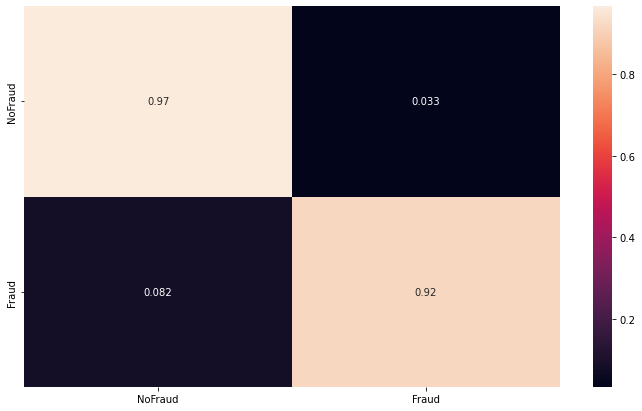

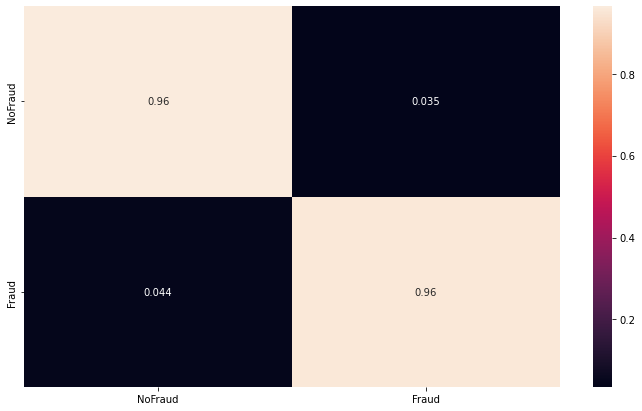

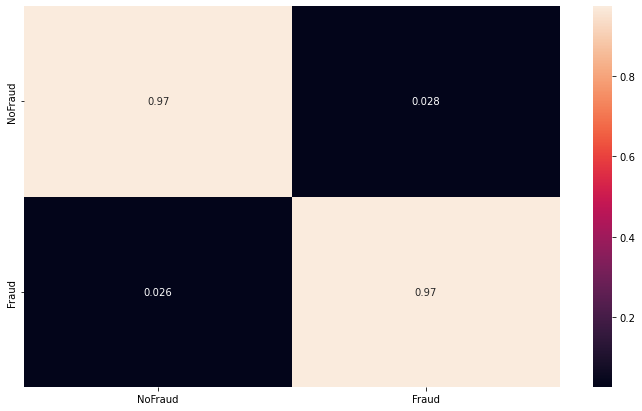

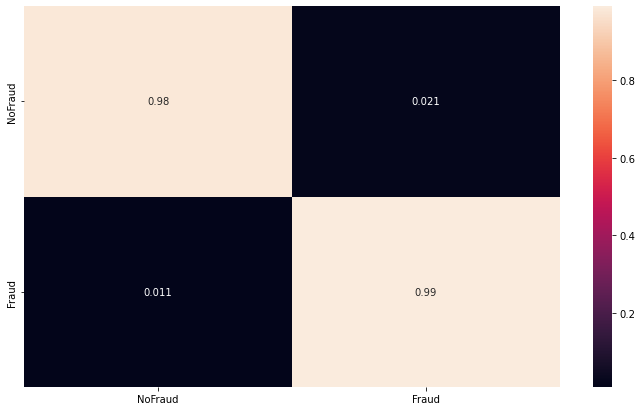

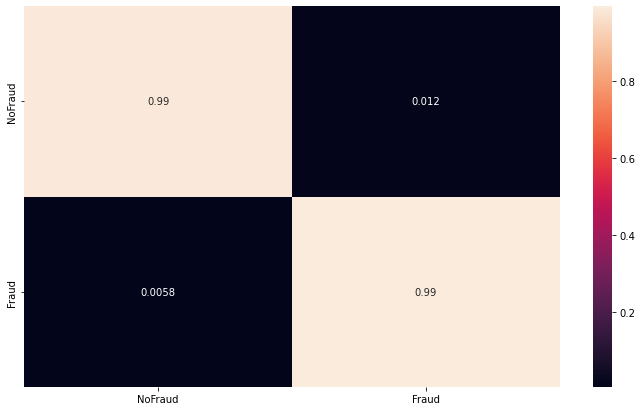

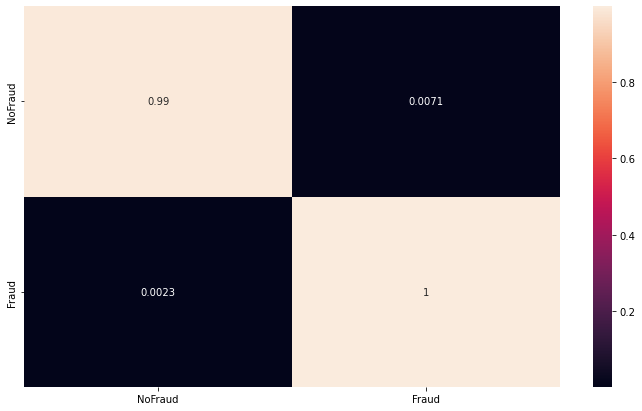

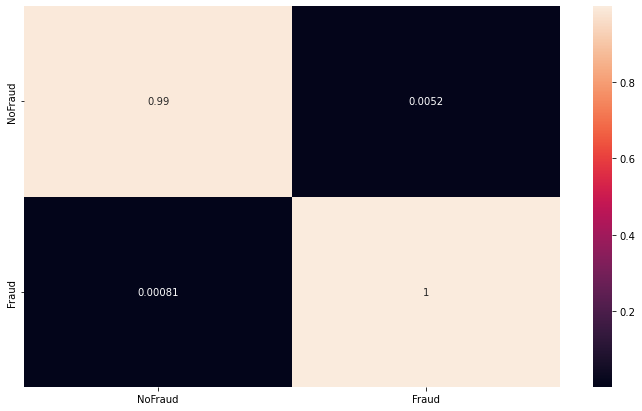

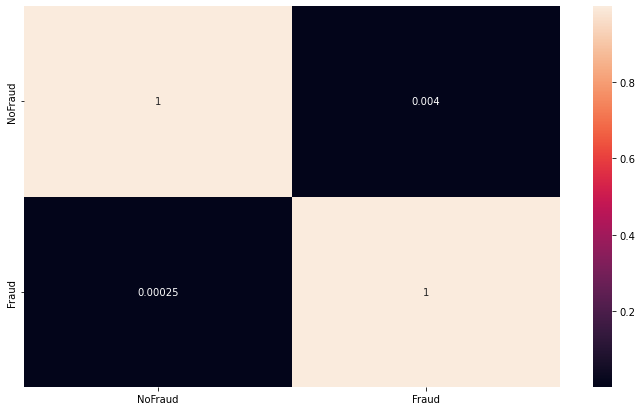

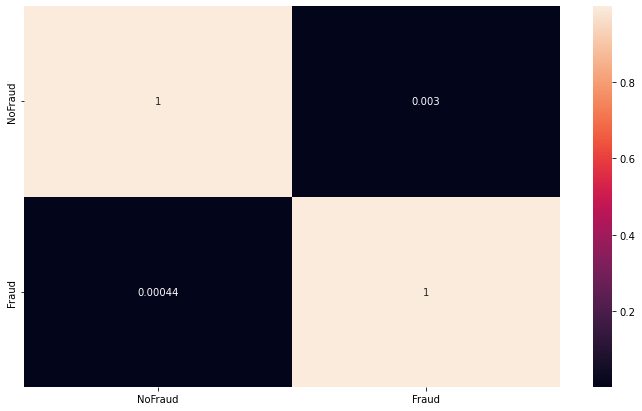

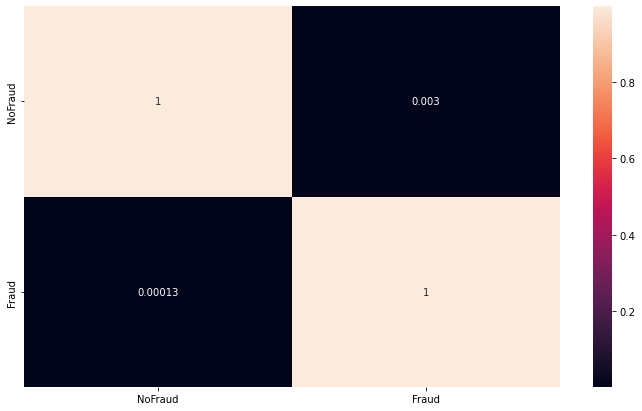

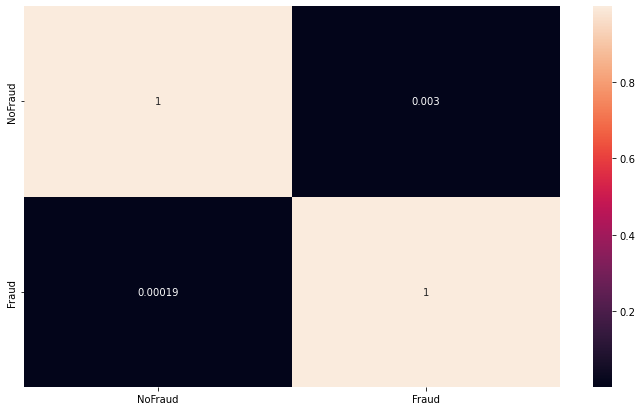

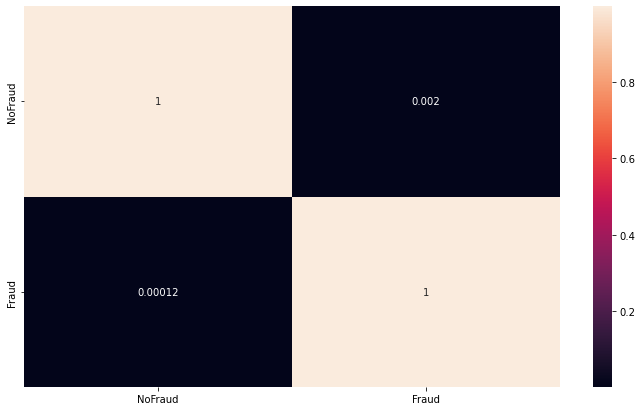

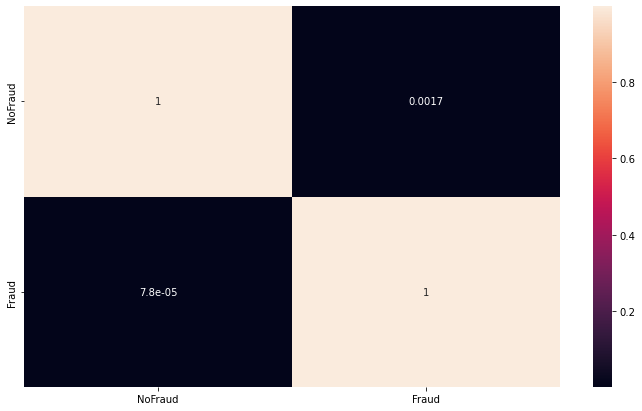

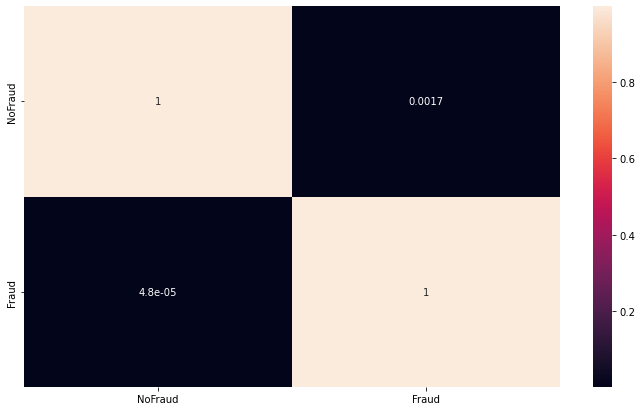

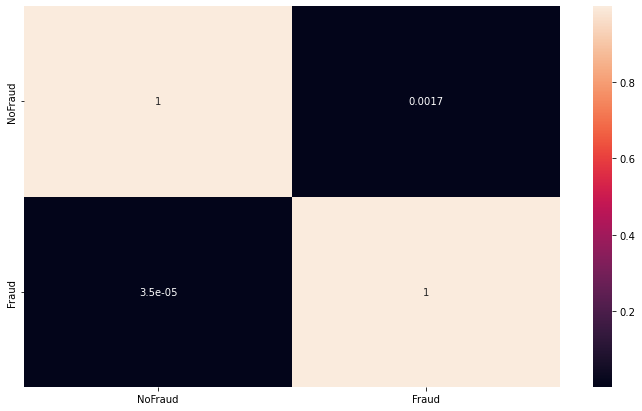

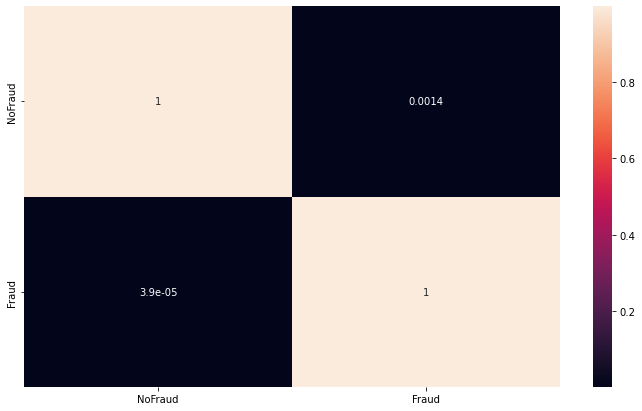

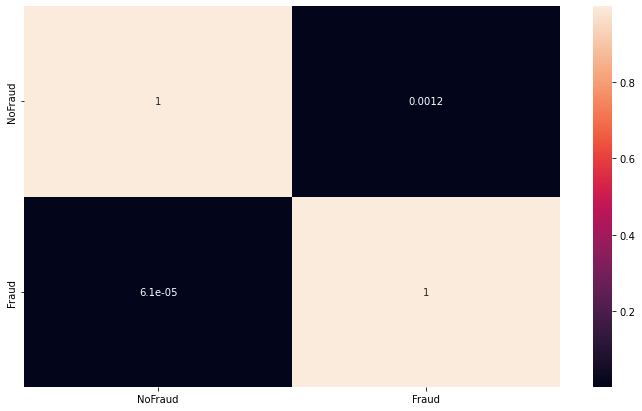

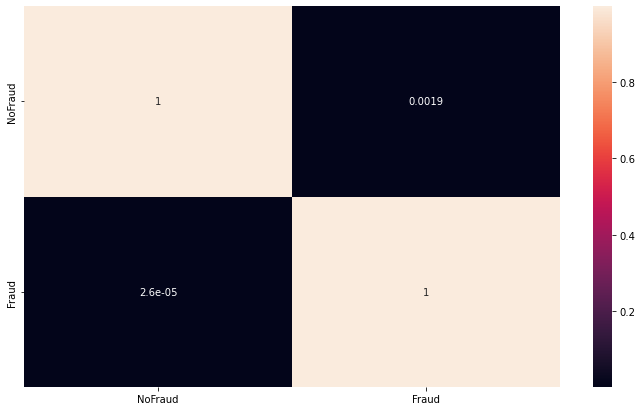

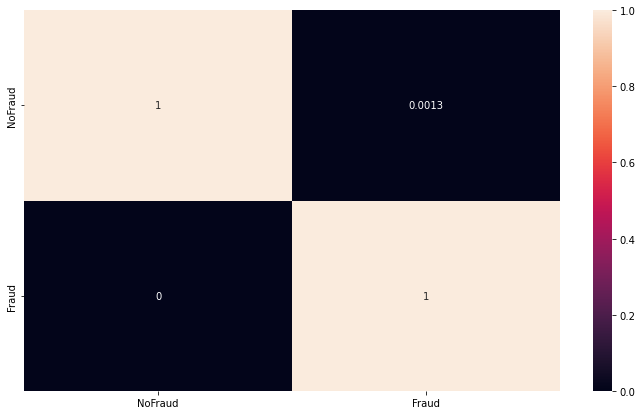

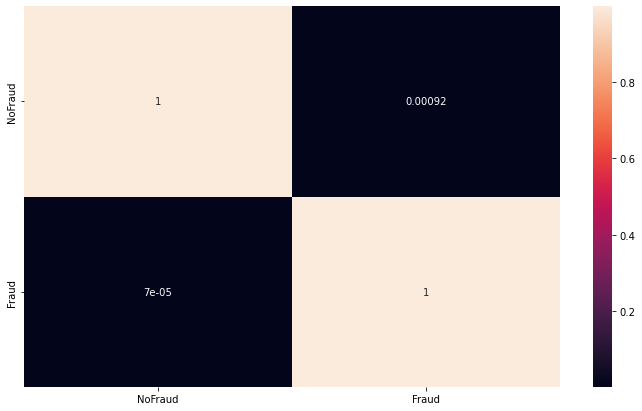

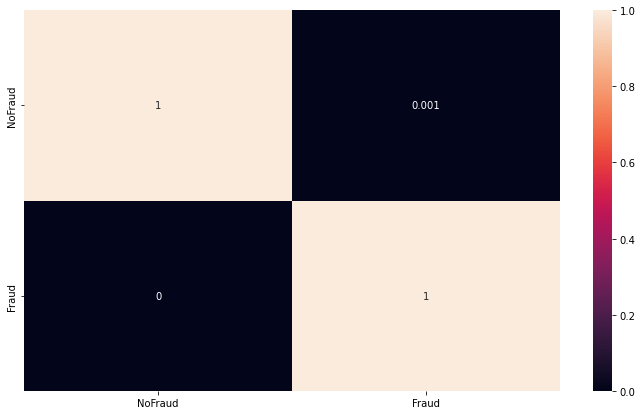

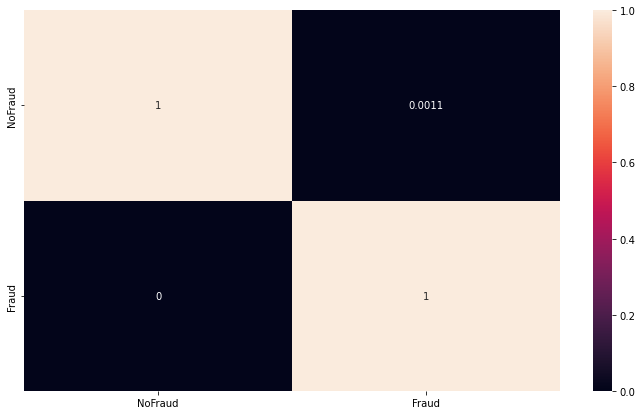

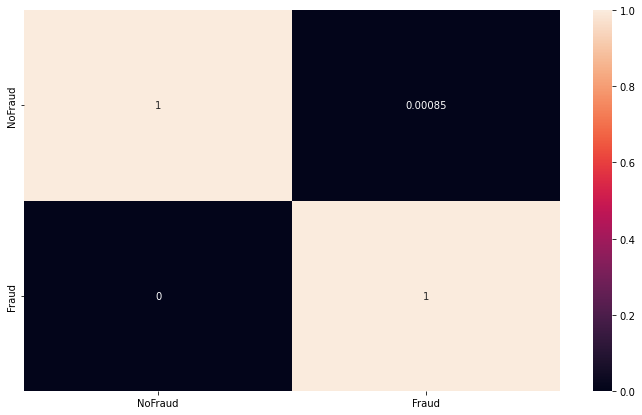

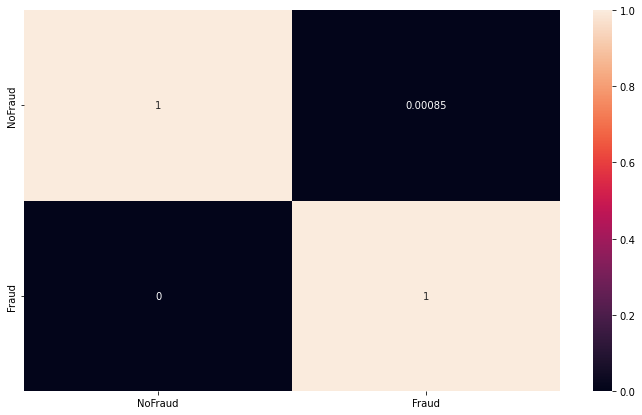

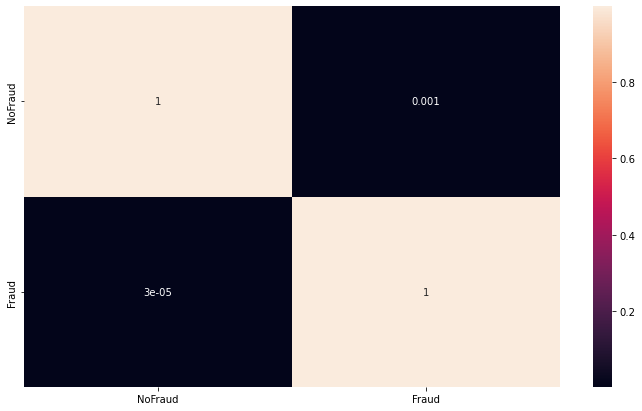

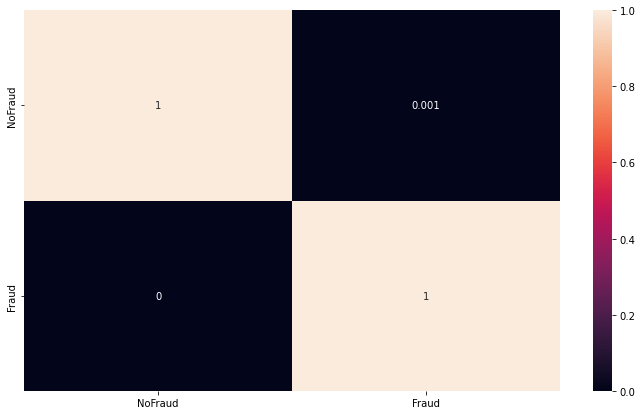

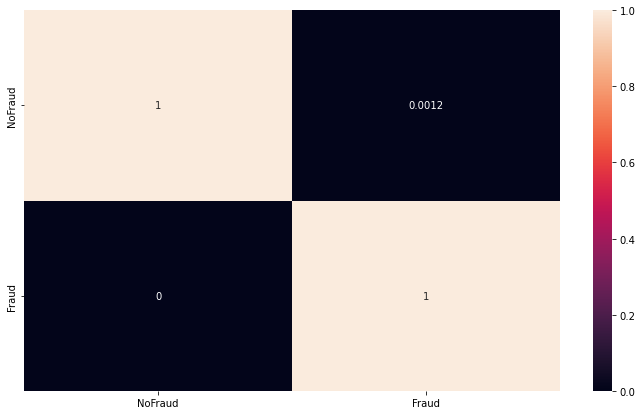

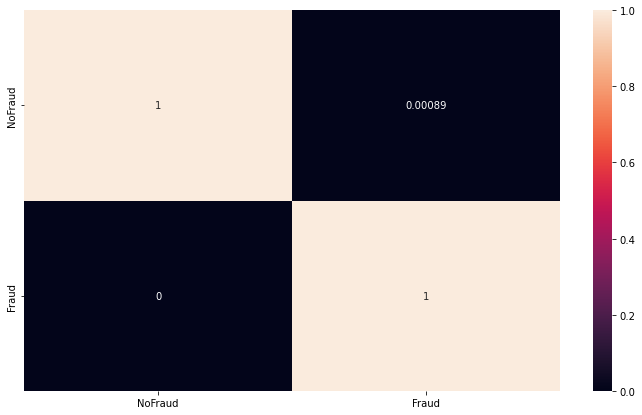

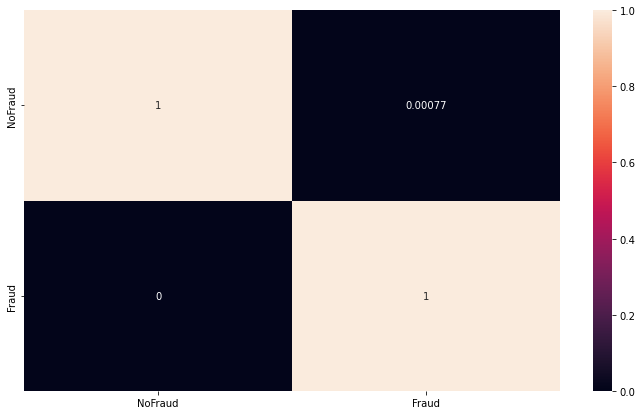

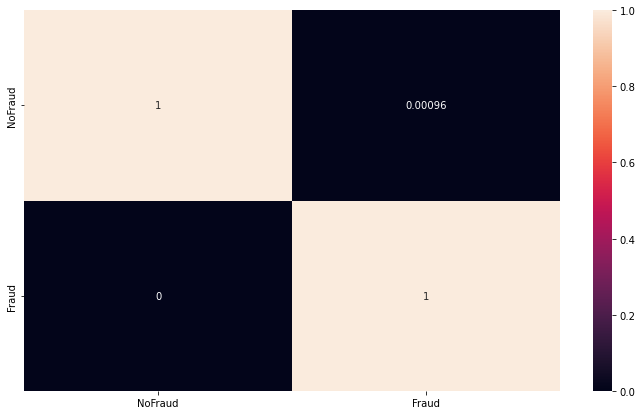

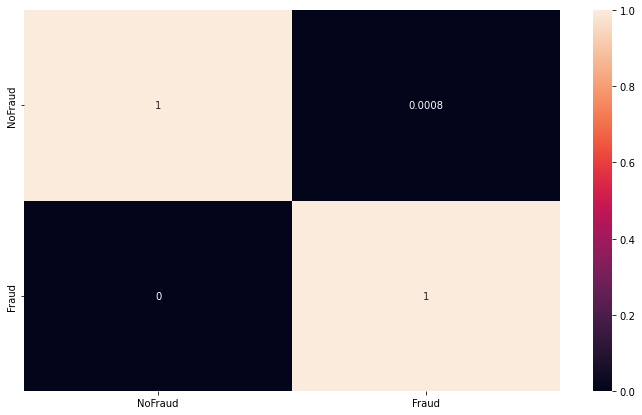

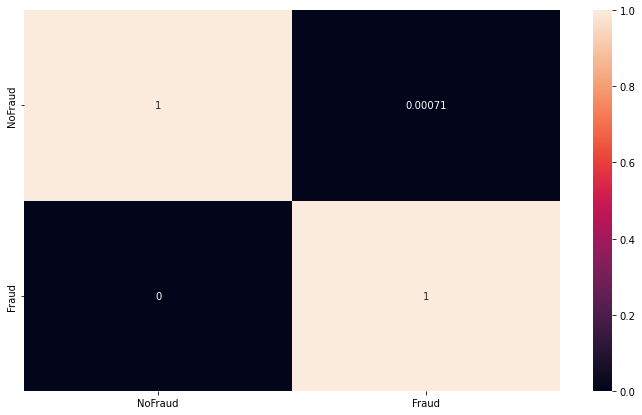

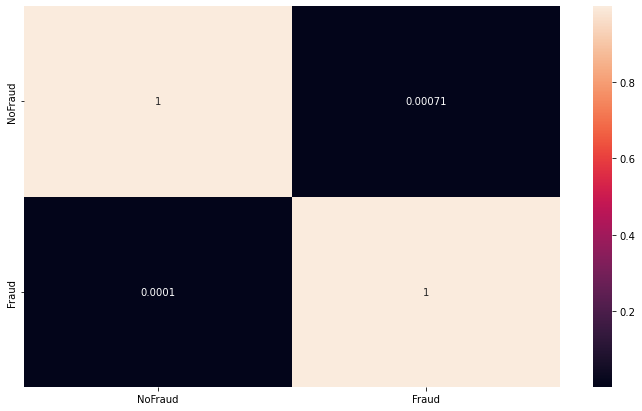

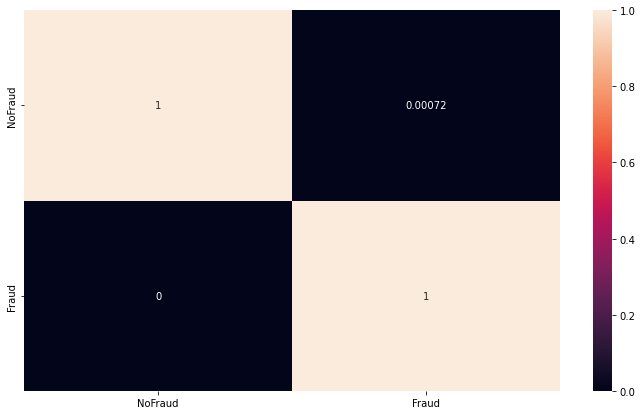

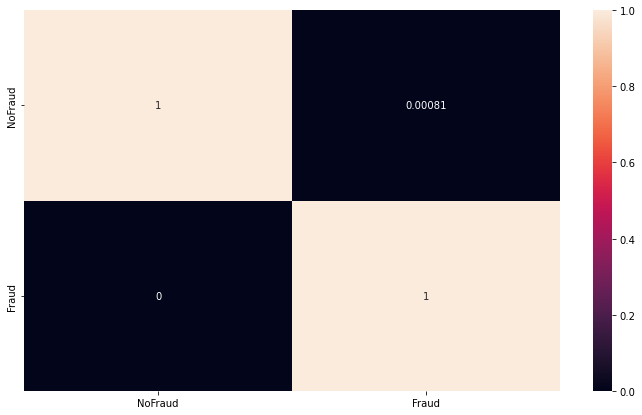

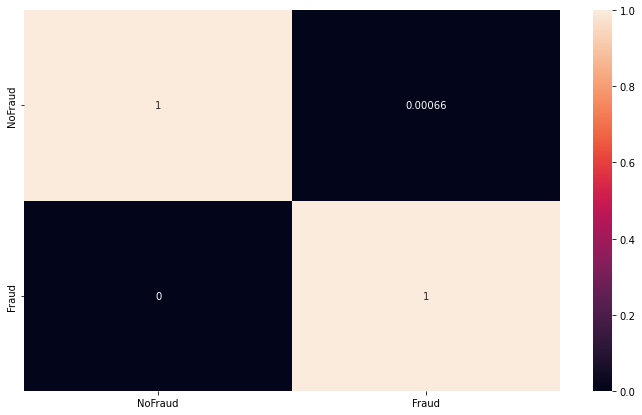

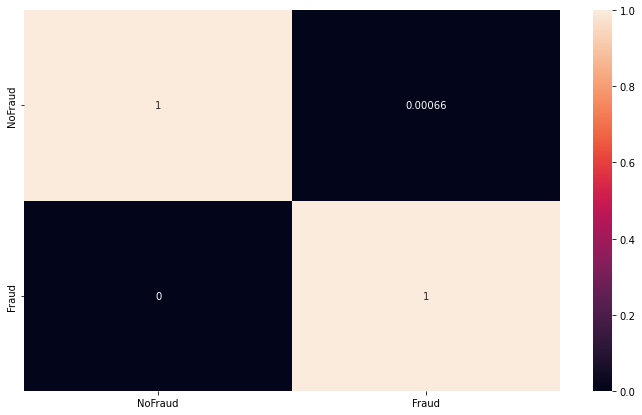

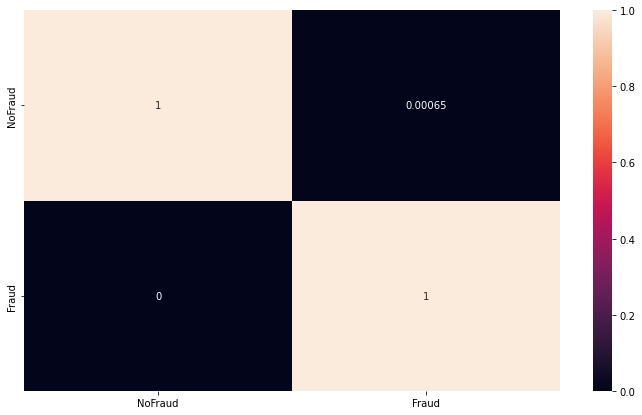

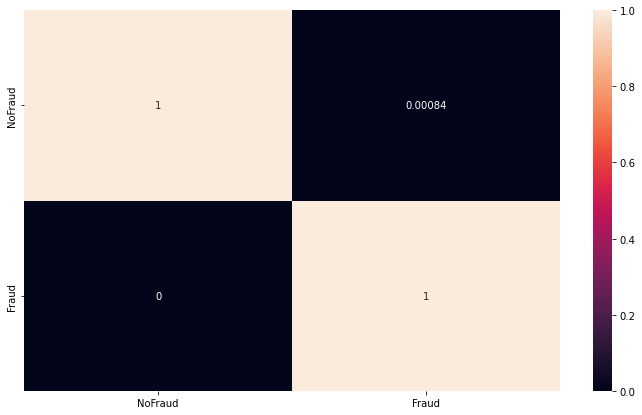

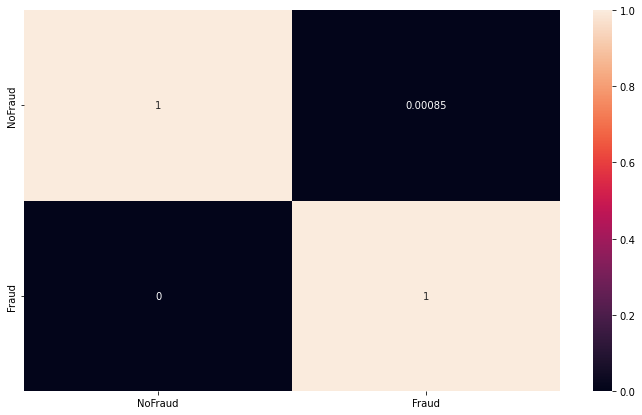

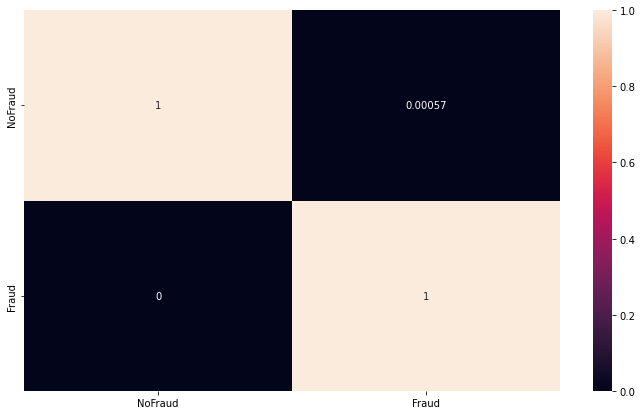

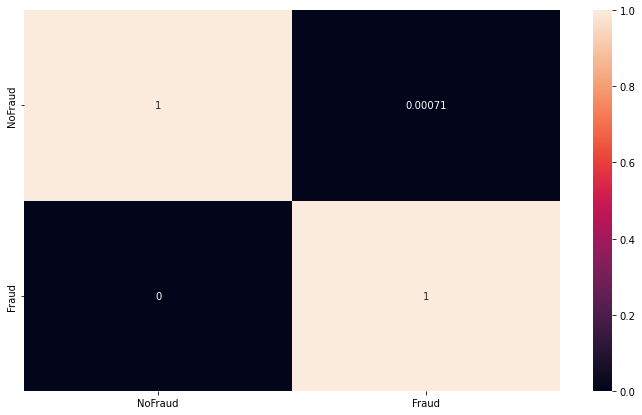

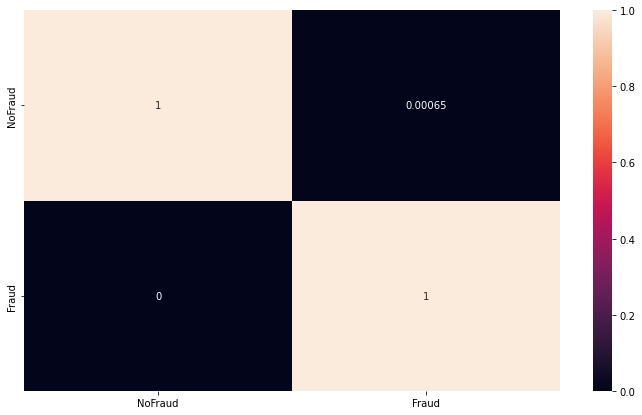

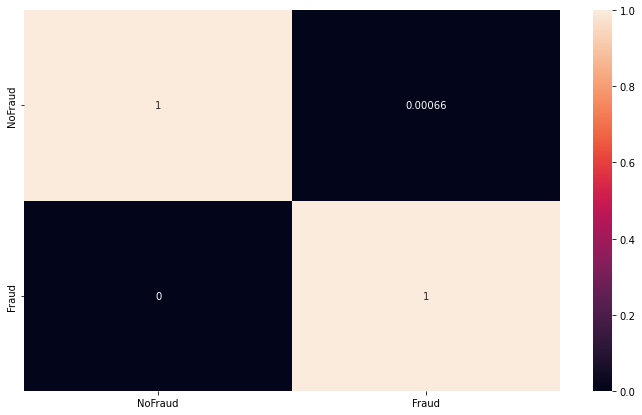

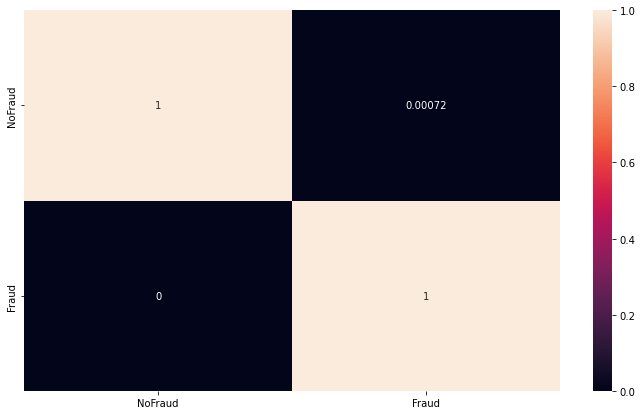

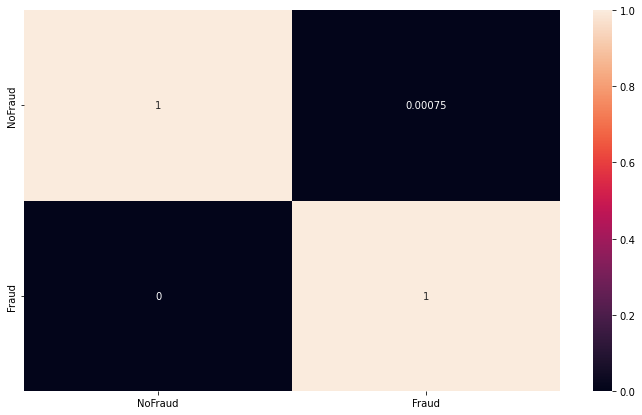

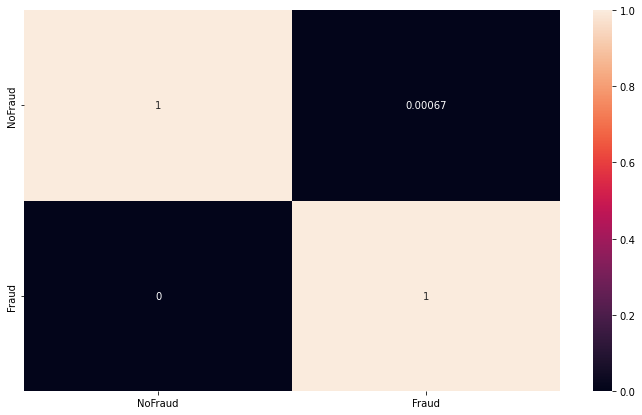

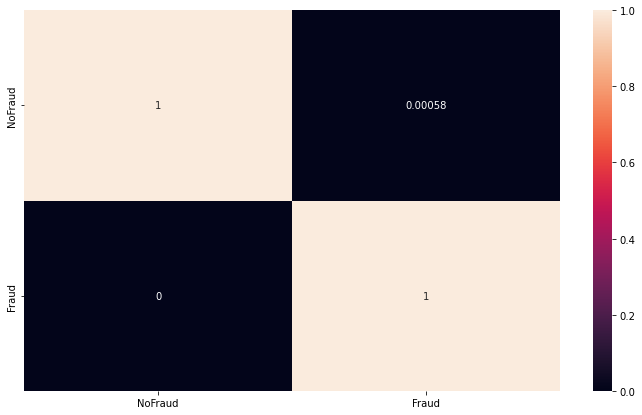

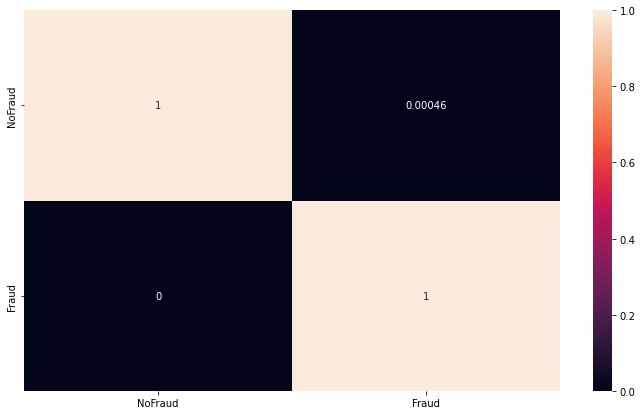

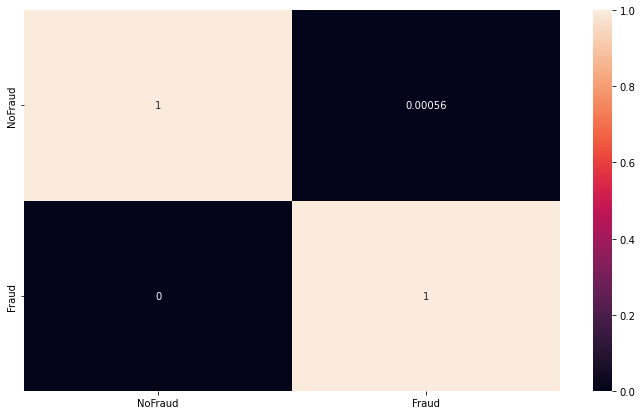

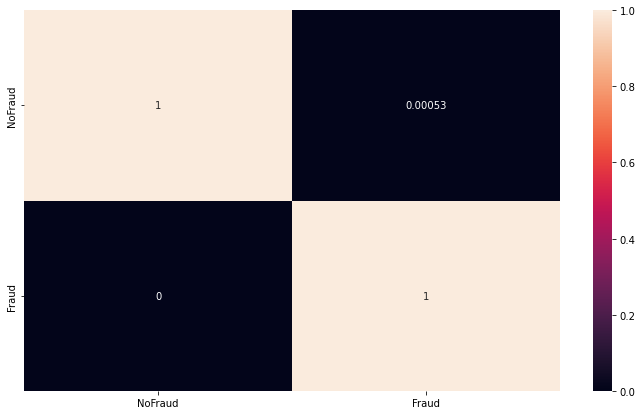

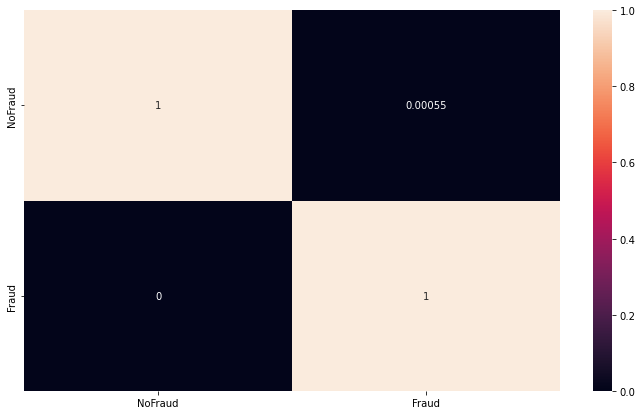

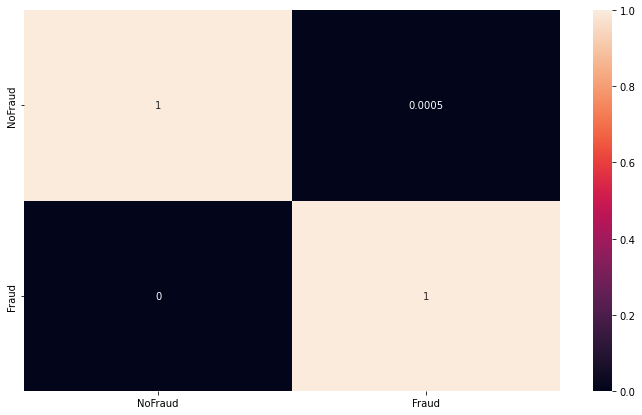

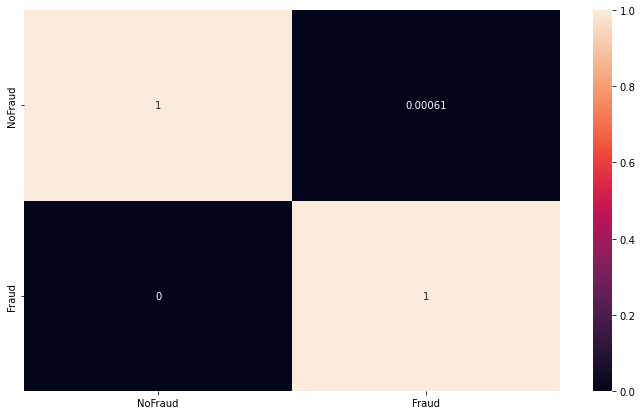

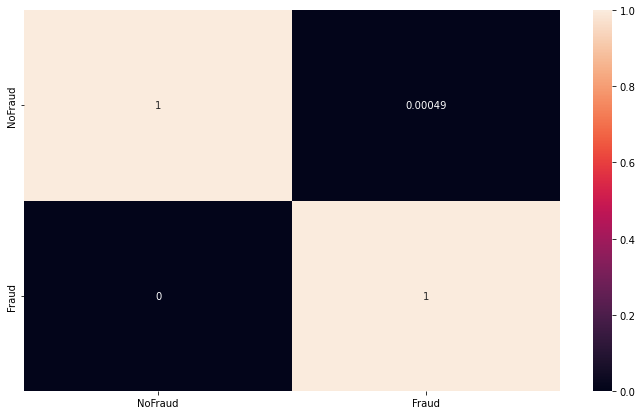

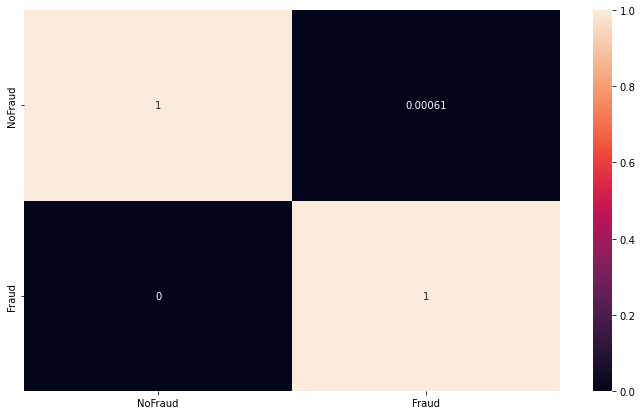

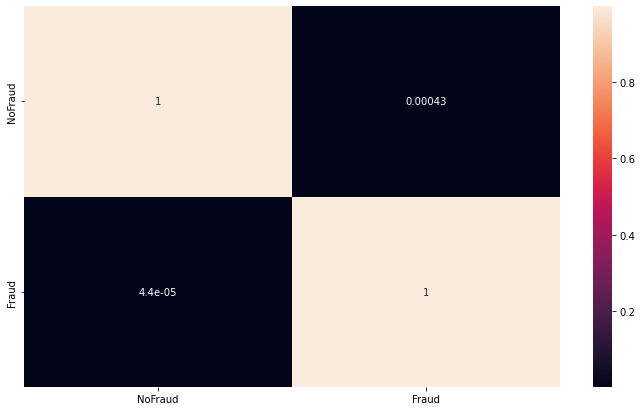

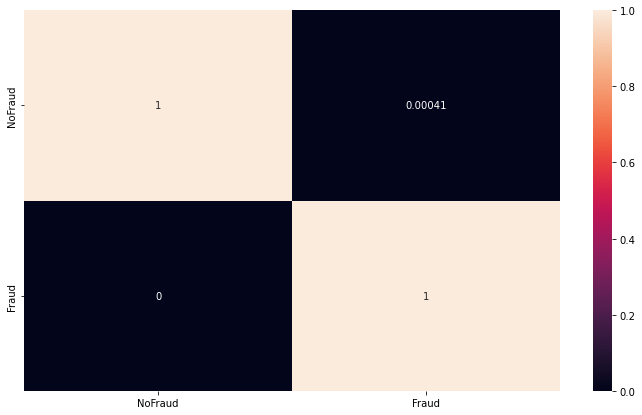

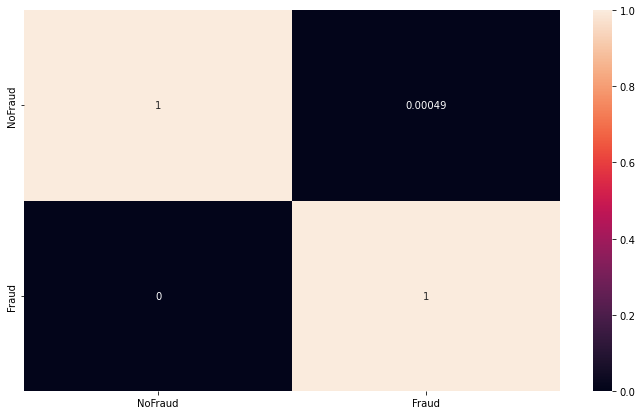

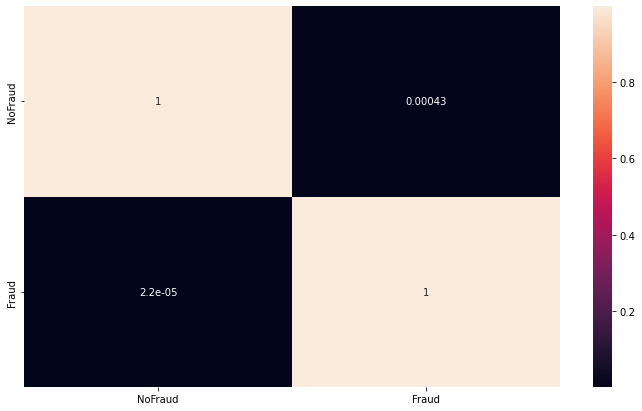

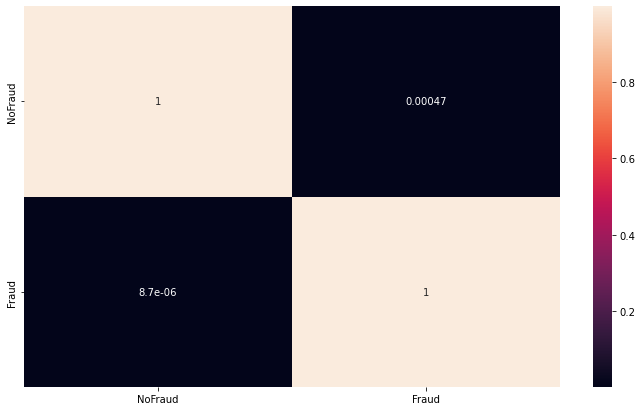

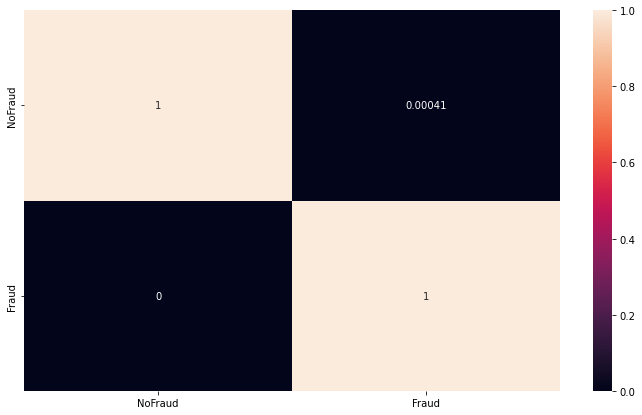

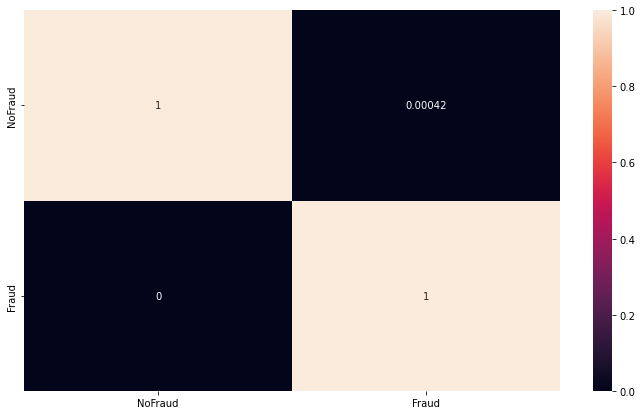

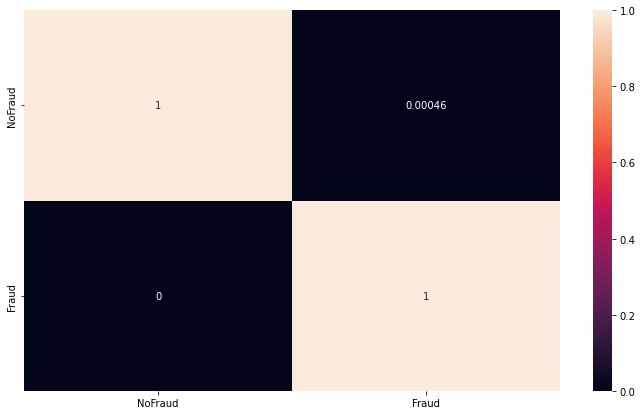

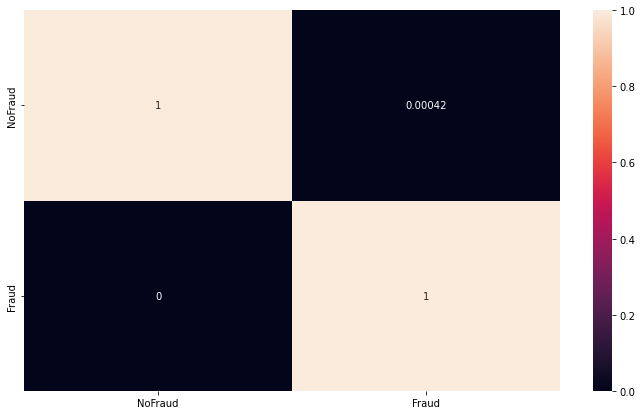

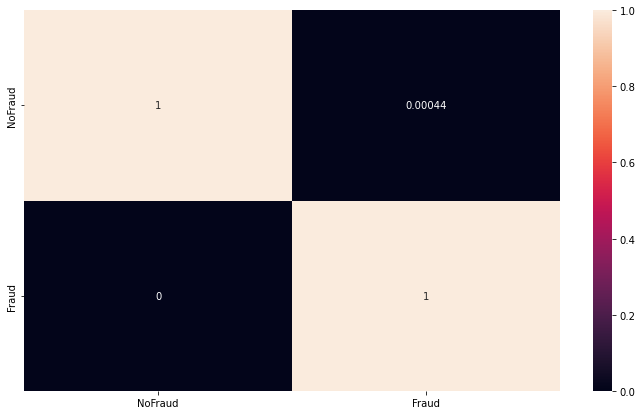

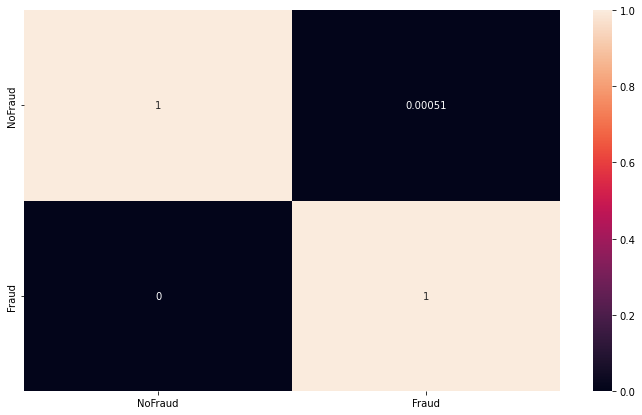

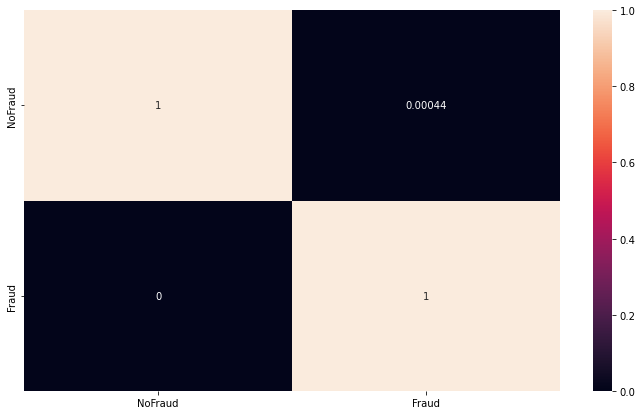

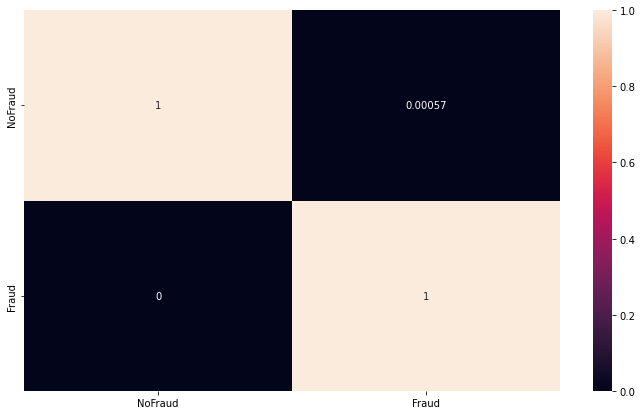

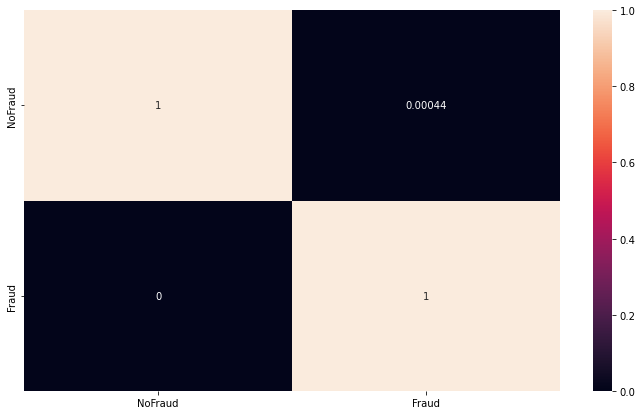

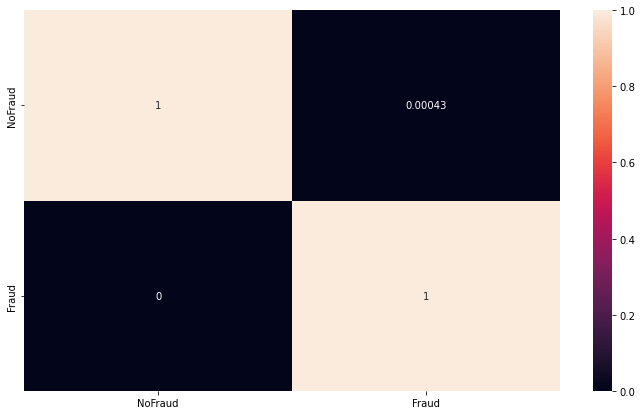

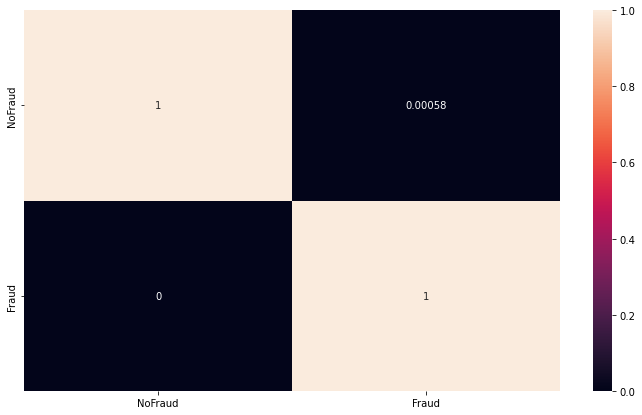

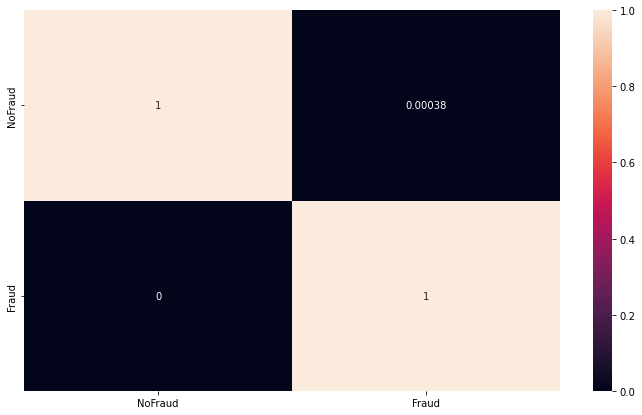

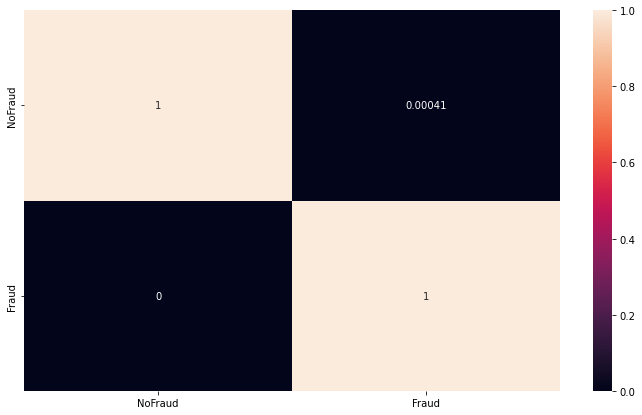

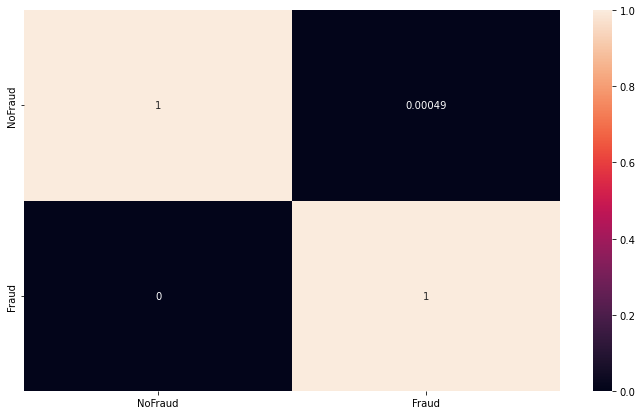

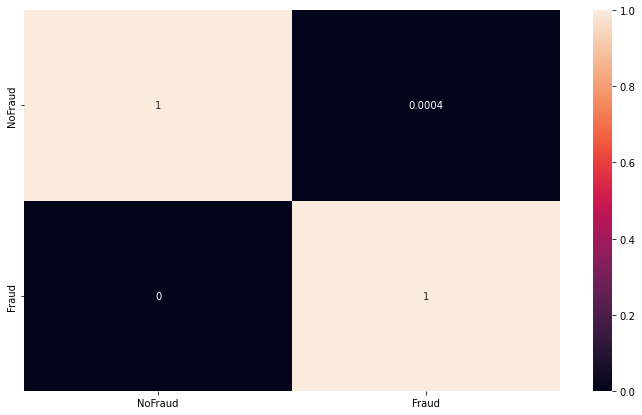

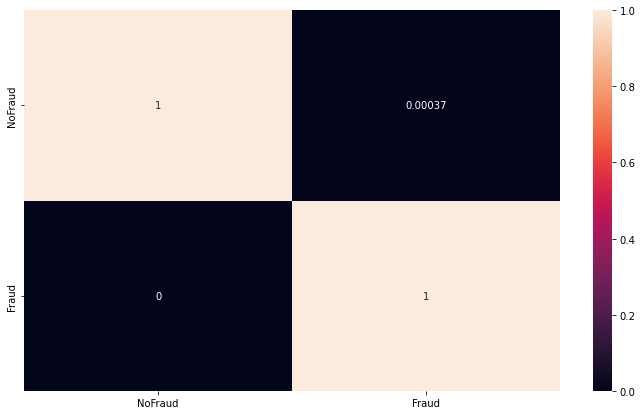

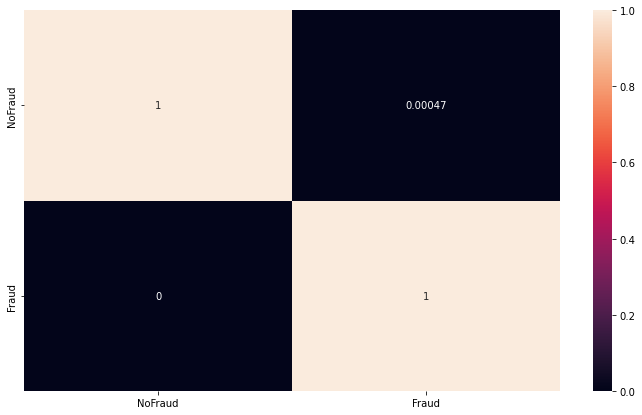

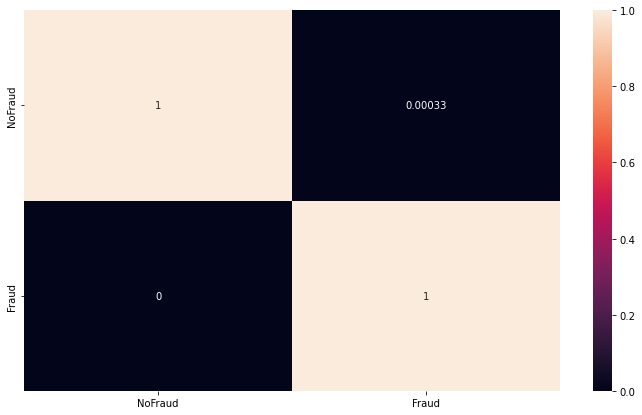

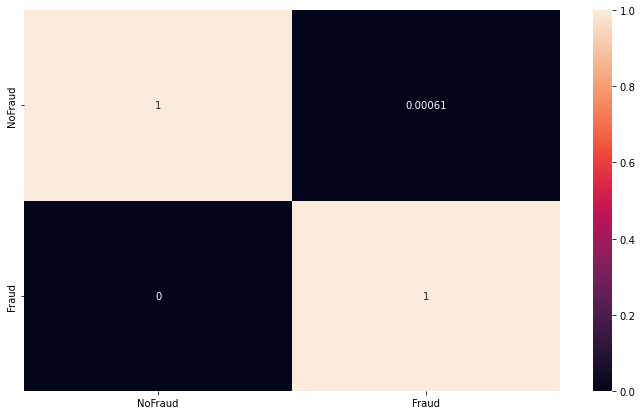

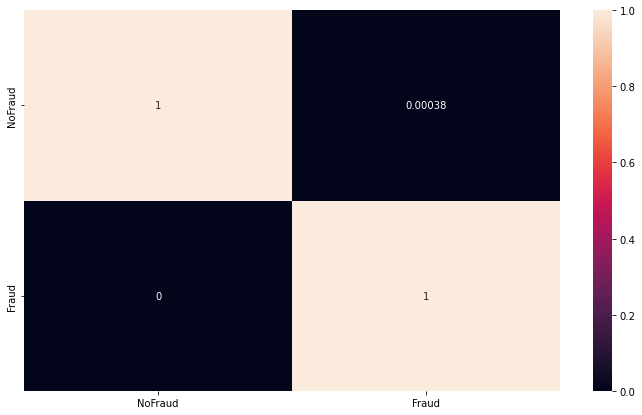

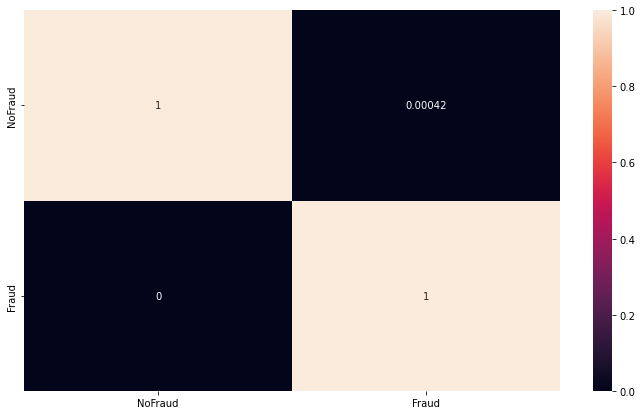

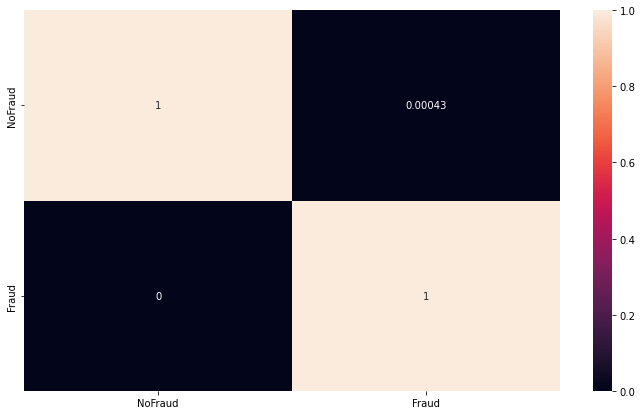

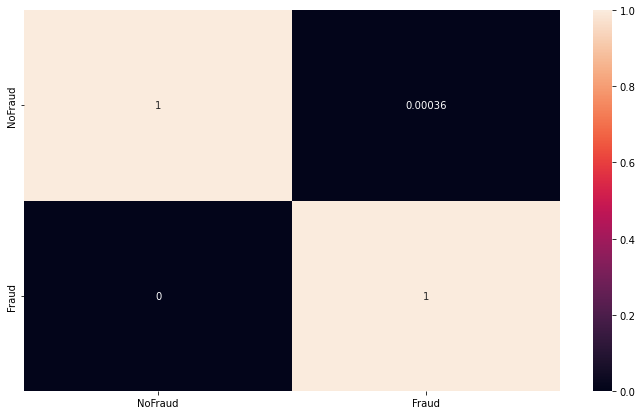

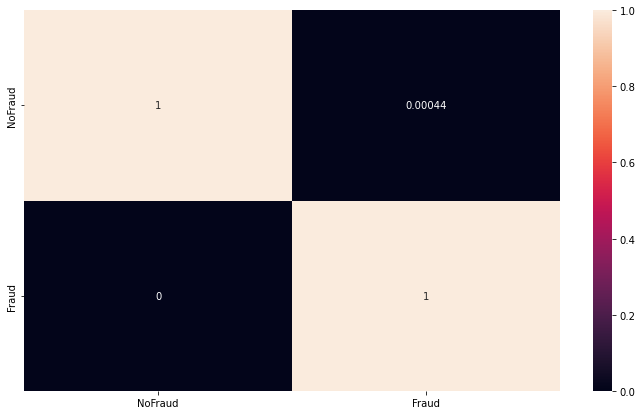

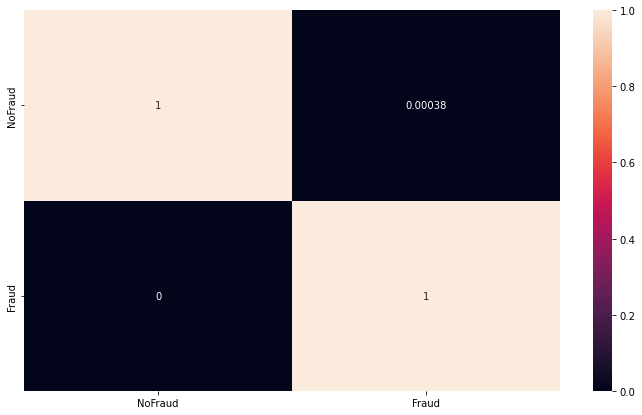

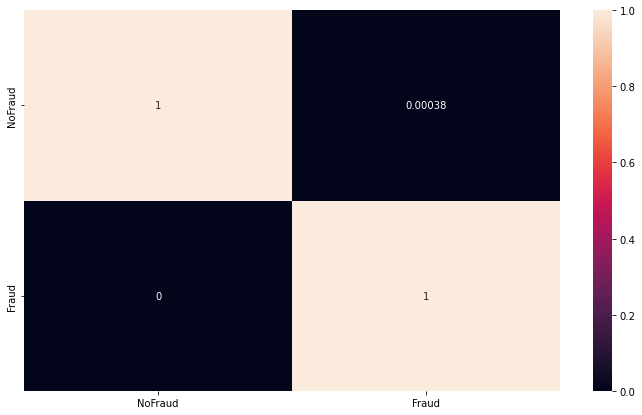

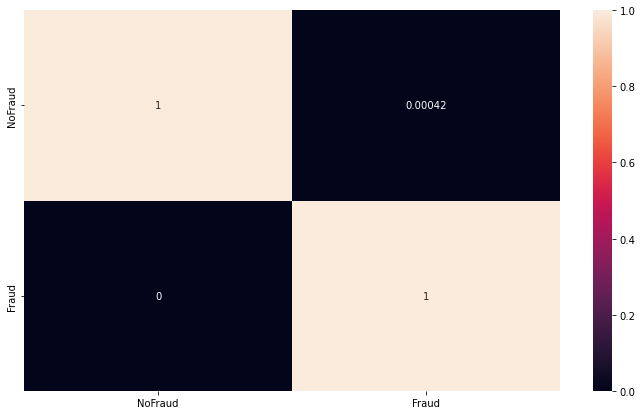

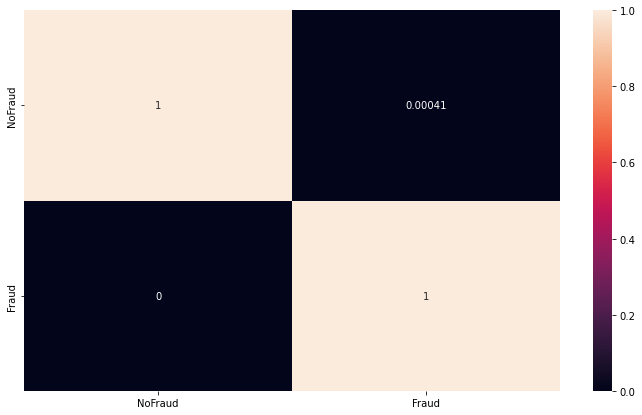

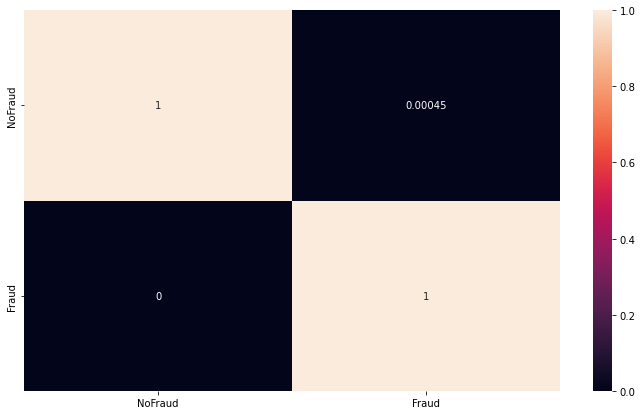

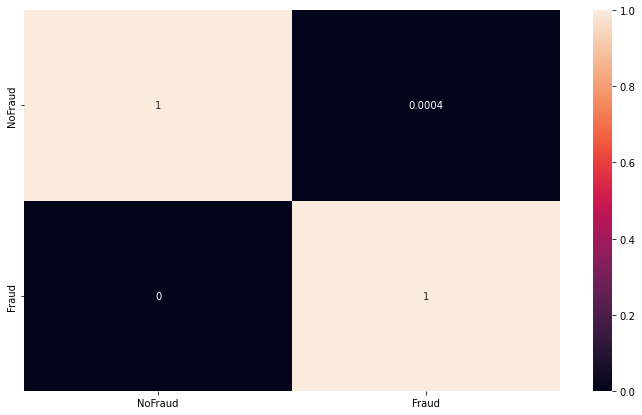

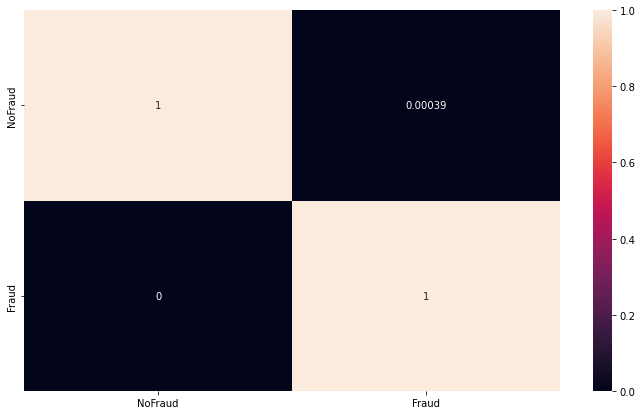

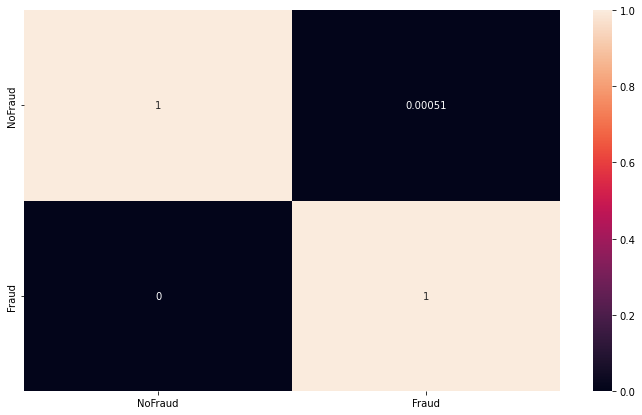

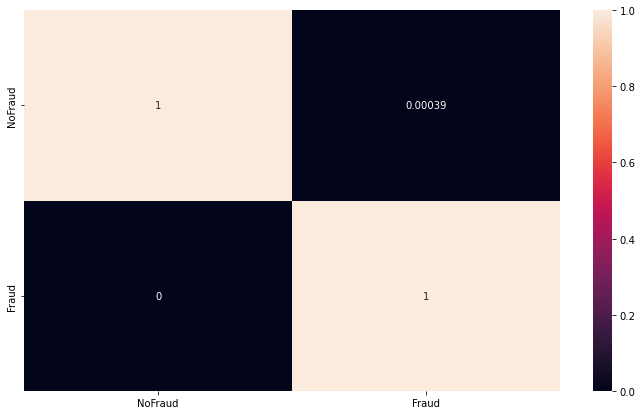

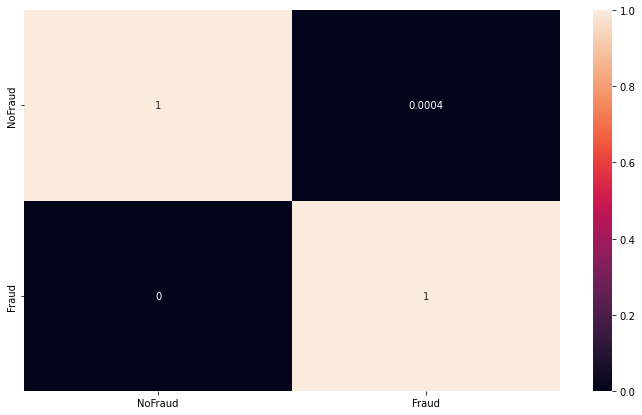

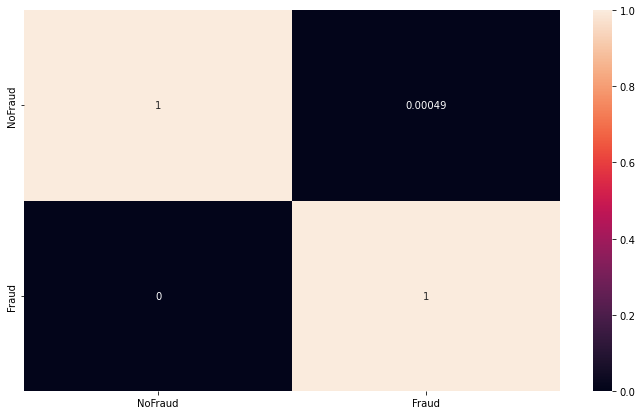

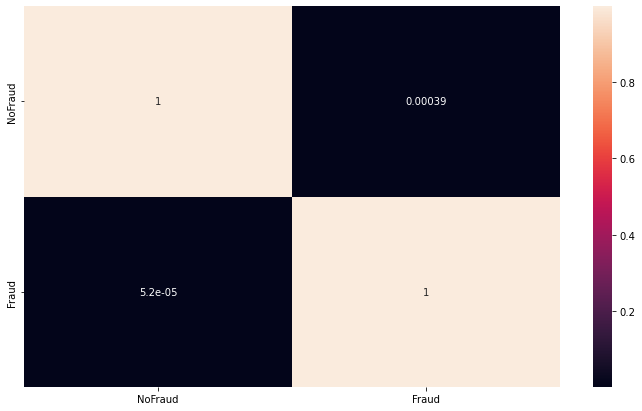

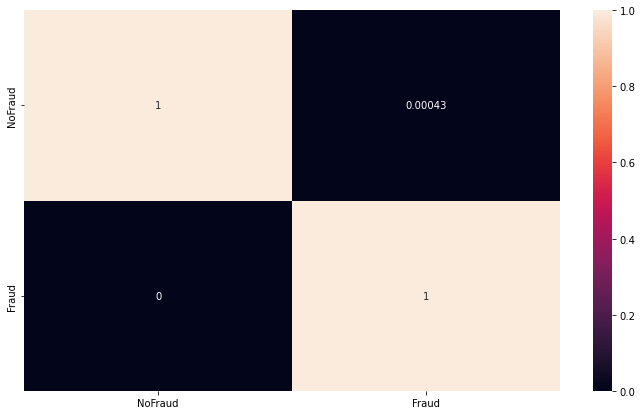

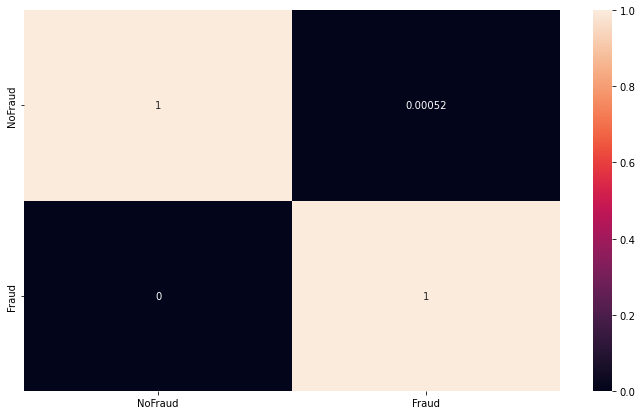

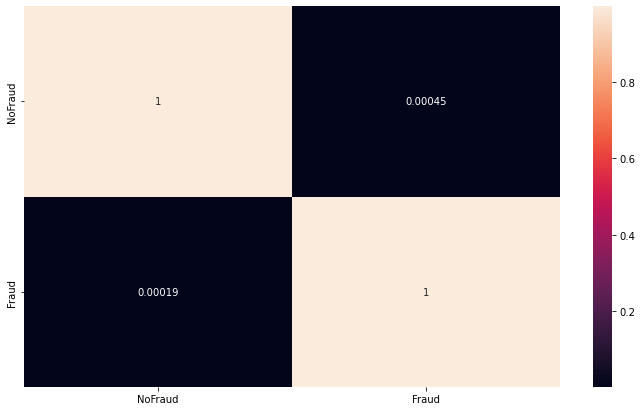

In [15]:
def compute_accuracy(model,features,targets):#, data_loader, device):
    correct_pred, num_examples = 0, 0
    features = features
    targets = targets
    logits, probas = model(features)
    _, predicted_labels = torch.max(probas, 1)
    num_examples += targets.size(0)
    correct_pred += (predicted_labels == targets).sum()

    print(classification_report(targets,predicted_labels))
    #Building Confusion matrix - https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

    # constant for classes
    classes = ('NoFraud','Fraud')

    # Build confusion matrix
    cf_matrix = confusion_matrix(targets, predicted_labels)
    #print(cf_matrix)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                         columns = [i for i in classes])
    #print(df_cm)
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

    #calculate f1_score
    print("F1 Score: ",f1_score(targets, predicted_labels))

    return correct_pred.float()/num_examples * 100


start_time = time.time()
minibatch_cost = []



#Split X (features) and y (targets) for the dataset
#X=np.delete(train_dataset,-1,axis=1)
#y = np.delete(train_dataset,np.s_[0:28],axis=1).flatten()
features_full = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets_full = torch.tensor(y, dtype=torch.long).to(DEVICE)
# create DataLoader, then take one batch

#Data loader for text data in Pytorch - https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/
#loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=16)
#for X_batch, y_batch in loader:
#    print(X_batch, y_batch)
#    break

for epoch in range(NUM_EPOCHS):

    loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=40000)
    model1.train()
    for batch_idx, (X_batch, y_batch) in enumerate(loader):
        print(epoch, len(X_batch), len(y_batch))
        ### FORWARD AND BACK PROP
        features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
        targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)
        logits, probas = model1(features)

        cost = F.cross_entropy(logits, targets)
        
        optimizer.zero_grad()

        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        #if not batch_idx % 50:
        print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
               %(epoch+1, NUM_EPOCHS, batch_idx, 
                 len(loader), cost))

    model1.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model1, features_full, targets_full)))#, train_loader, device=DEVICE)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [16]:
df_train.head()

,amount_scaled,time_scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.146720,0.437963,2.072815,-0.274020,-1.461536,0.390729,0.169042,-0.451219,0.002638,-0.174516,...,-0.214453,0.098887,0.527270,-0.001204,0.550820,0.245880,0.709438,-0.078027,-0.067661,0
1,1.445476,-0.102051,-4.970521,3.432079,-5.314765,4.094720,-3.890290,-1.799163,-5.099047,2.143258,...,0.235769,1.121876,0.136211,-0.367362,0.156025,0.100632,-0.235917,0.212967,0.755191,1
2,-0.289387,1.017681,2.013691,-0.108723,-1.007693,0.323577,-0.145682,-0.946591,0.071817,-0.184335,...,-0.227993,-0.233649,-0.582757,0.341730,0.072900,-0.346356,0.173302,-0.075417,-0.069613,0
3,-0.305736,0.833645,-1.887328,0.856580,0.660617,-0.643041,-0.261658,-0.052315,-0.832577,0.273245,...,-0.568695,0.753342,-0.618488,-0.149734,-0.516402,-0.275556,-0.595123,-0.128462,-0.119148,0
4,-0.293440,-0.179866,1.239337,0.622954,-0.249949,1.318213,-0.028978,-1.213163,0.254201,-0.208548,...,-0.146088,-0.059217,-0.130362,-0.111587,0.259646,0.669972,-0.325467,0.027764,0.049900,0


<br>
<br>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.65      0.89      0.75        74

    accuracy                           1.00     42722
   macro avg       0.82      0.95      0.87     42722
weighted avg       1.00      1.00      1.00     42722

F1 Score:  0.7499999999999999
Test accuracy: 99.90%


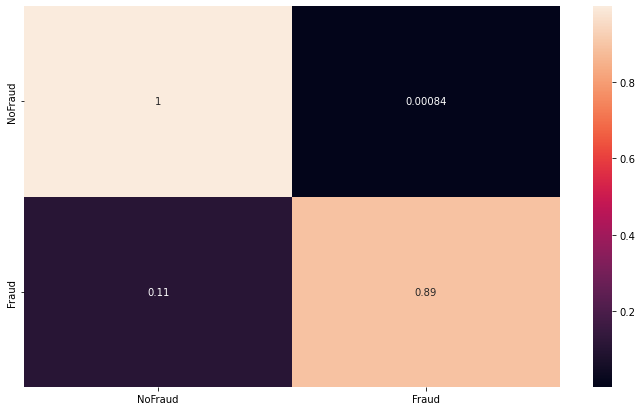

In [17]:
##########################
### Evaluation and Acccuracy Confusion Matrix
##########################

#Split X (features) and y (targets) for the test dataset
X=np.delete(test_dataset,-1,axis=1)
y = np.delete(test_dataset,np.s_[0:30],axis=1).flatten()
features = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets = torch.tensor(y, dtype=torch.long).to(DEVICE)


with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model1, features, targets)))

In [18]:
df_test

,amount_scaled,time_scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.690771,0.456737,1.825390,-1.077621,-1.470206,0.717307,-0.120429,0.526675,-0.287993,0.030873,...,-0.404411,-0.172303,0.020379,-0.121985,0.214216,0.367291,-0.400787,0.013981,-0.036774,0
1,5.886257,0.469977,1.100822,-1.751982,-1.179405,-0.142146,-1.283041,-1.036085,0.034555,-0.118941,...,0.703302,0.021856,-0.828514,0.096684,0.399532,-0.931244,0.193015,-0.112093,0.049565,0
2,0.469503,-0.166132,1.489310,-1.168616,-0.405391,-1.551548,-0.776875,-0.044639,-0.773565,-0.085285,...,-0.237593,-0.212885,-0.232211,-0.274822,-0.821830,0.778783,-0.012738,0.001131,-0.006071,0
3,2.766716,-0.476909,0.814388,-0.862222,0.912719,0.417587,-1.284266,-0.404437,-0.318470,-0.102405,...,0.449386,0.213571,0.348421,-0.229960,0.528373,0.176248,1.081888,-0.067926,0.054866,0
4,4.421295,-0.075083,0.765733,-1.409727,-0.246736,-0.187071,-1.132248,-0.925154,0.296619,-0.449901,...,0.248825,-0.234840,-0.764921,-0.311339,0.481325,0.350838,1.052800,-0.123750,0.058177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42717,4.423950,0.361999,1.341398,-1.132099,-2.089190,0.530681,-0.095425,-0.413697,0.304192,-0.037911,...,0.437838,-0.007934,-0.632443,-0.054904,0.570772,-0.256907,-0.169727,-0.082469,0.029950,0
42718,6.855865,-0.140239,-0.686183,-1.294687,0.388873,-0.440192,-1.576549,0.637076,-0.993550,-2.770456,...,1.949784,-0.985986,0.372241,-0.511325,-0.326889,0.370319,0.233185,0.079850,0.347964,0
42719,0.446308,-0.067588,1.300448,-0.557344,0.419697,-0.557177,-1.140793,-1.038534,-0.352959,-0.246905,...,-0.368435,-0.615450,-1.438292,0.203983,0.378886,-0.054361,0.732372,-0.062765,0.022632,0
42720,-0.137637,0.960467,2.218149,-0.703405,-1.403045,-1.177214,-0.188104,-0.510869,-0.473433,-0.230111,...,0.063857,0.373992,1.117838,-0.044661,-0.727803,0.154496,-0.009787,-0.024651,-0.076596,0
